In [ ]:
import numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bisect import bisect_left, bisect_right
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import learning_curve, GroupKFold
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, kmeans_plusplus, Birch, BisectingKMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from collections import Counter
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrameGroupBy.apply operated on the grouping columns.*"
)

# Data Preprocessing and Feature Enigneering

In [2]:
def load_data(interference_file_name: str) -> pd.DataFrame:
    interference_df = pd.read_csv(interference_file_name, low_memory=False)

    # Encode info, channel columns to dummies
    columns_to_encode = ['info', 'channel']

    for col in columns_to_encode:
        interference_df = pd.get_dummies(interference_df, columns=[col], prefix='is')

    # Keep all relevant columns having an is_* prefix, drop the rest
    channels_to_keep = ['is_37', 'is_38', 'is_39', 'is_ADV_IND', 'is_ADV_NONCONN_IND', 'is_SCAN_REQ', 'is_ADV_EXT_IND', 'is_ADV_SCAN_IND', 'is_AUX_ADV_IND', 'is_adv_channel' ,'is_broadcast']
    other_channel_cols = [col for col in interference_df.columns if col.startswith('is_') and col not in channels_to_keep]
    interference_df = interference_df.drop(columns=other_channel_cols)
    # CHANGED: add missing dummy channels
    missing_channels = [ch for ch in channels_to_keep if ch not in interference_df.columns]
    for ch in missing_channels:
        interference_df[ch] = False



    return interference_df

In [3]:
# Calculate some source-based feature columns
def calculate_features(actual_df: pd.DataFrame, aggregated_df: pd.DataFrame) -> pd.DataFrame:
    actual_df = actual_df.sort_values(by=['source', 'time'])
    actual_df['time_to_next'] = actual_df.groupby('source')['time'].shift(-1) - actual_df['time']
    actual_df['time_to_next'] = actual_df['time_to_next'].fillna(0)
    actual_df = actual_df.sort_values(by=['source', 'time'])
    actual_df['time_diff'] = actual_df.groupby('source')['time'].diff()

    group_means = aggregated_df['mean_time_between_packets']
    actual_df['mean_time_between_packets'] = actual_df['source'].map(group_means)
    actual_df['mean_time_between_packets'] = actual_df['mean_time_between_packets'].fillna(0)

    sd_group_means = aggregated_df['service_data_mean_length']
    actual_df['service_data_mean_length'] = actual_df['source'].map(sd_group_means)
    actual_df['service_data_mean_length'] = actual_df['service_data_mean_length'].fillna(0)

    actual_df['packet_send_freq'] = actual_df['time_to_next'] / actual_df['mean_time_between_packets']
    actual_df['packet_send_freq'] = actual_df['packet_send_freq'].fillna(0)

    actual_df['service_data_len_ratio'] = actual_df['service_data'].str.len() / actual_df['service_data_mean_length']
    actual_df['service_data_len_ratio'] = actual_df['service_data_len_ratio'].fillna(0)

    ad_type_group_means = aggregated_df['ad_type_mean_length']
    actual_df['ad_type_mean_length'] = actual_df['source'].map(ad_type_group_means)
    actual_df['ad_type_mean_length'] = actual_df['ad_type_mean_length'].fillna(0)
    actual_df['ad_type_len_ratio'] = actual_df['ad_type'].str.len() / actual_df['ad_type_mean_length']
    actual_df['ad_type_len_ratio'] = actual_df['ad_type_len_ratio'].fillna(0)

    data_group_means = aggregated_df['data_mean_length']
    actual_df['data_mean_length'] = actual_df['source'].map(data_group_means)
    actual_df['data_mean_length'] = actual_df['data_mean_length'].fillna(0)
    actual_df['data_len_ratio'] = actual_df['data'].str.len() / actual_df['data_mean_length']
    actual_df['data_len_ratio'] = actual_df['data_len_ratio'].fillna(0)

    uuid16_group_means = aggregated_df['uuid16_mean_length']
    actual_df['uuid16_mean_length'] = actual_df['source'].map(uuid16_group_means)
    actual_df['uuid16_mean_length'] = actual_df['uuid16_mean_length'].fillna(0)
    actual_df['uuid16_len_ratio'] = actual_df['uuid16'].str.len() / actual_df['uuid16_mean_length']
    actual_df['uuid16_len_ratio'] = actual_df['uuid16_len_ratio'].fillna(0)

    # Drop intermediate columns as they were only used to help the calculation
    actual_df = actual_df.drop(columns=['mean_time_between_packets', 'time_diff', 'service_data_mean_length', 'ad_type_mean_length', 'data_mean_length', 'uuid16_mean_length'])
    
    return actual_df

In [4]:
# Group dataframe by source and extract some metrics
def aggregate_features(group_filter: str, input_df: pd.DataFrame) -> pd.DataFrame:
    input_df = input_df.sort_values(by=['source', 'time'])
    input_df['time_diff'] = input_df.groupby('source')['time'].diff()

    agg_df = input_df.groupby(group_filter).agg(
        ad_type_mean_length=('ad_type', lambda x: x.str.len().mean()),
        data_mean_length=('data', lambda x: x.str.len().mean()),
        uuid16_mean_length=('uuid16', lambda x: x.str.len().mean()),
        service_data_mean_length=('service_data', lambda x: x.str.len().mean()),
        mean_time_between_packets=('time_diff', 'mean'),
    )
    
    return agg_df

In [5]:
def combine_data(interference_df: pd.DataFrame, target_labels: list) -> pd.DataFrame:
    # Aggregate dataframe by source and calculate new columns
    interfered_df_agg = aggregate_features('source', interference_df)
    interfered_df_calc = calculate_features(interference_df, interfered_df_agg)

    interfered_df_calc['group_label'] = interfered_df_calc['labelled_device'].apply(
        lambda x: 1 if x in target_labels else 0
    )

    return interfered_df_calc

In [ ]:
##############################
#        CODE FIELD 1        # 
##############################

# List of target labels
target_list = ['Phone', 'Buds', 'Smart Tag']

# Load all datasets and calculate aggregated features
apart_df_1 = load_data('../data/samsung_labeled/int_apart_labeled_1.csv')
apart_df_2 = load_data('../data/samsung_labeled/int_apart_labeled_2.csv')
apart_df_3 = load_data('../data/samsung_labeled/int_apart_labeled_3.csv')
df_4 = load_data('../data/samsung_labeled/samsung_uni_group3_2h_labeled.csv') # samsung_isolated_group2_6h_labeled, samsung_isolated_group3_6h_labeled, samsung_uni_group3_2h_labeled
int_apart_1 = combine_data(apart_df_1, target_list)
int_apart_2 = combine_data(apart_df_2, target_list)
int_apart_3 = combine_data(apart_df_3, target_list)
int_df_4 = combine_data(df_4, target_list)

print(f'Length Apartment 1 Dataset: {len(int_apart_1)}')
print(f'Length Apartment 2 Dataset: {len(int_apart_2)}')
print(f'Length Apartment 3 Dataset: {len(int_apart_3)}')
print(f'Length Dataset 4: {len(int_df_4)}')

Length Apartment 1 Dataset: 2571127
Length Apartment 2 Dataset: 2613096
Length Apartment 3 Dataset: 2427052
Length Dataset 4: 3340540


In [7]:
##############################
#        CODE FIELD 2        #
##############################

# Create time-based features by counting packets within time windows per source
dataframes = [int_apart_1, int_apart_2, int_apart_3, int_df_4]

for i in range(len(dataframes)):
    df = dataframes[i].sort_values(by=['source', 'time']).reset_index(drop=True)

    df['packets_within_1s'] = 0
    df['packets_within_100ms'] = 0
    df['packets_within_25ms'] = 0
    df['packets_within_2ms'] = 0
    df['time'] = df['time'].astype(float)

    def count_within_window(group, window, col_name):
        times = group['time'].values
        counts = []
        for t in times:
            left = bisect_left(times, t - window)
            right = bisect_right(times, t + window)
            counts.append(right - left - 1)
        group[col_name] = counts
        return group

    df = df.groupby('source', group_keys=False).apply(count_within_window, window=1.0, col_name='packets_within_1s')
    df = df.groupby('source', group_keys=False).apply(count_within_window, window=0.1, col_name='packets_within_100ms')
    df = df.groupby('source', group_keys=False).apply(count_within_window, window=0.025, col_name='packets_within_25ms')
    df = df.groupby('source', group_keys=False).apply(count_within_window, window=0.002, col_name='packets_within_2ms')

    # Re-assign updated DataFrame
    dataframes[i] = df

int_apart_1, int_apart_2, int_apart_3, int_df_4 = dataframes

In [8]:
# Will ensure that only n(=max_entries) values per source address may be part of a dataset
def create_balanced_df(input_df: pd.DataFrame, max_entries: int=1000) -> pd.DataFrame:
    output_df = (
    input_df.groupby(['source'])
    .apply(lambda x: x.sample(min(len(x), max_entries), random_state=1))
    .reset_index(drop=True)
    )

    print(len(output_df))
    return output_df

# Bin the column by assigning into quantiles, equal/duplicate quantiles are dropped
def bin_column(df_to_edit: pd.DataFrame, column_to_bin: str, binned_column_name: str, quantile_amount: int = 15) -> pd.DataFrame:
    qcut_result = pd.qcut(df_to_edit[column_to_bin], q=quantile_amount, duplicates='drop')
    df_to_edit[binned_column_name] = qcut_result.cat.codes
    return df_to_edit

In [9]:
##############################
#        CODE FIELD 3        #
##############################

# Renaming config of binned columns
binning_config = {
    'len_ad_type':  'len_ad_type_binned',
    'len_data':  'len_data_binned',
    'len_uuid16':  'len_uuid16_binned',
    'len_service_data':  'len_service_data_binned',
    'time_start_end':  'time_start_end_binned',
    'delta_end_start':  'delta_end_start_binned',
    'delta_start_start':  'delta_start_start_binned',
    'packet_send_freq':  'packet_send_freq_binned',
    'time_to_next':  'time_to_next_binned',
    'uuid16_len_ratio': 'uuid16_len_ratio_binned',
    'data_len_ratio': 'data_len_ratio_binned',
    'ad_type_len_ratio': 'ad_type_len_ratio_binned',
}

# Define all dataframes for modeling
train_df_large = pd.concat([int_apart_1, int_apart_2, int_apart_3])
train_df_medium = pd.concat([int_apart_1, int_apart_2])
train_df_binned_large = train_df_large.copy()
train_df_binned_medium = train_df_medium.copy()
eval_df = int_df_4.copy()
eval_df_binned = eval_df.copy()


# Create binned dataframes with 15 quantiles
max_bins = 15
for column, new_column in binning_config.items():
    train_df_binned_large = bin_column(train_df_binned_large, column, new_column, max_bins)
    train_df_binned_medium = bin_column(train_df_binned_medium, column, new_column, max_bins)
    eval_df_binned = bin_column(eval_df_binned, column, new_column, max_bins)

# Create balanced dataframes limiting to max 1000 entries per source
train_df_large_balanced = create_balanced_df(train_df_large.copy(), max_entries=1000)
train_df_medium_balanced = create_balanced_df(train_df_medium.copy(), max_entries=1000)
train_df_binned_large_balanced = create_balanced_df(train_df_binned_large.copy(), max_entries=1000)
train_df_binned_medium_balanced = create_balanced_df(train_df_binned_medium.copy(), max_entries=1000)
eval_balanced = create_balanced_df(eval_df.copy(), max_entries=1000)
eval_df_binned_balanced = create_balanced_df(eval_df_binned.copy(), max_entries=1000)

1127616
758799
1127616
758799
1177196
1177196


In [10]:
df_train_group_0 = train_df_binned_large_balanced[train_df_binned_large_balanced["labelled_device"] == "empty"]
df_train_group_1 = train_df_binned_large_balanced[train_df_binned_large_balanced["labelled_device"] != "empty"]
print(f"Training set 1: Noise {round(100*(len(df_train_group_0)/len(train_df_binned_large_balanced)), 2)}, Target Group {round(100*(len(df_train_group_1)/len(train_df_binned_large_balanced)), 2)}")

df_eval_group_0 = eval_df_binned_balanced[eval_df_binned_balanced["labelled_device"] == "empty"]
df_eval_group_1 = eval_df_binned_balanced[eval_df_binned_balanced["labelled_device"] != "empty"]
print(f"Evaluation set 1: Noise {round(100*(len(df_eval_group_0)/len(eval_df_binned_balanced)), 2)}, Target Group {round(100*(len(df_eval_group_1)/len(eval_df_binned_balanced)), 2)}")

Training set 1: Noise 53.79, Target Group 46.21
Evaluation set 1: Noise 94.39, Target Group 5.61


# Supervised Learning

In [11]:
def split_data(base_df: pd.DataFrame, X: pd.DataFrame, y: pd.Series, test_size: float, split_mode_group: bool=False):
  # Split with the train_test_split method
  if not split_mode_group:
    X_train, X_test, y_train, y_test = train_test_split(
      X, y, stratify=y, test_size=test_size, random_state=1, shuffle=True)

  # Split by grouping by source addresses with GroupShuffleSplit
  elif split_mode_group:
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=1)

    train_idx, test_idx = next(gss.split(X, y, groups=base_df.source))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

  return X_train, X_test, y_train, y_test

In [12]:
def fit_and_predict_model(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.DataFrame, model):
  model = model.fit(X_train, y_train)

  # 5-fold cross-validation
  train_acc = accuracy_score(y_train, model.predict(X_train))
  test_acc = accuracy_score(y_test, model.predict(X_test))
  cv_scores = cross_val_score(model, X_train, y_train, cv=5)

  print(f'Train Accuracy: {train_acc:.4f}')
  print(f'Test Accuracy:  {test_acc:.4f}')
  print(f'CV Accuracy (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

  y_pred = model.predict(X_test)
  return model, y_pred

In [13]:
def create_matrix(model,
                  y_test: pd.Series,
                  y_pred: numpy.ndarray,
                  model_name: str,
                  split_mode: bool=False,
                  model_type: str='Training'
                  ):
  cm = confusion_matrix(y_test, y_pred, normalize='true')
  grouping = 'Grouped' if split_mode else 'Regular'

  # Show matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot(cmap=plt.cm.Blues, values_format='.2%')
  plt.title(f'{model_name} - {model_type} - {grouping}')
  plt.tight_layout()
  plt.show()

In [14]:
def evaluate_model(model,
                   model_name: str,
                   eval_df: pd.DataFrame,
                   split_mode: bool=False,
                   balance_mode: bool=False
                   ):
  X_new = eval_df.drop(columns=dropped_columns + ['group_label'])
  y_new_pred = model.predict(X_new)
  y_true = eval_df['group_label']

  print('Evaluation on Test Dataset:')
  print(classification_report(y_true, y_new_pred))

  create_matrix(
            model = model,
            y_test = y_true,
            y_pred = y_new_pred,
            model_name = model_name,
            split_mode=split_mode,
            model_type='Evaluation'
        )

In [15]:
def model_feature_importance(model, X_test: pd.DataFrame,
                             y_test: pd.Series,
                             model_name: str,
                             model_type: str):
    all_feature_names = X_test.columns

    # Only Random Forest has native feature importance
    if 'Random Forest' in model_name:
        model_features = model.feature_importances_
        importance_df = pd.DataFrame({
                'Feature': all_feature_names,
                'Importance': model_features
            }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['Feature'][:10][::-1], importance_df['Importance'][:10][::-1])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 10 Features: Random Forest - {model_type}')
        plt.tight_layout()
        plt.show()
    else:
        perm_result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=1)
        importance_df = pd.DataFrame({
            'Feature': all_feature_names,
            'Importance': perm_result.importances_mean
            }).sort_values(by='Importance', ascending=False)

        print('\nPermutation Importance:')
        print(importance_df.head(10))

        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['Feature'][:10][::-1], importance_df['Importance'][:10][::-1])
        plt.xlabel('Permutation Importance')
        plt.title(f'Top 10 Features: {model_name} - {model_type}')
        plt.tight_layout()
        plt.show()

In [ ]:
##############################
#        CODE FIELD 4        #
##############################

# # Separate classes
df_0 = eval_df_binned_balanced[eval_df_binned_balanced['group_label'] == 0].copy()
df_1 = eval_df_binned_balanced[eval_df_binned_balanced['group_label'] == 1].copy()

# Randomly undersample class 0 (=noise)
df_0_downsampled = resample(df_0,
                            replace=False,
                            n_samples=2*len(df_1),
                            random_state=1)

# Create downsampled evaluation dataset
eval_df_balanced_down = pd.concat([df_0_downsampled, df_1])

In [17]:
# These columns are dropped before training and not used for supervised learning
dropped_columns = [
    'time',
    'source',
    'destination',
    'length',
    'rssi',
    'company_id',
    'device_name',
    'uuid16',
    'uuid128',
    'data',
    'ad_type',
    'service_data',
    'crc',
    'labelled_device',
    'sublabel_device',
    'packet_send_freq',
    'time_to_next',
    'time_start_end',
    'delta_end_start',
    'delta_start_start',
    'len_ad_type',
    'len_data',
    'len_uuid16',
    'len_service_data',
    'has_uuid128',
    'uuid16_len_ratio',
    'data_len_ratio',
    'ad_type_len_ratio',
    'len_uuid16_binned',
    'len_service_data_binned',
    'uuid16_len_ratio_binned',
]

# Defines the train/test split ratio
test_param = 0.3

# If only one model should be run at a time, simply comment out the other two models
model_dict = {
    'Random Forest': RandomForestClassifier(random_state=1,
                                            class_weight='balanced',
                                            n_estimators=50,
                                            min_samples_split=10,
                                            min_samples_leaf=3,
                                            min_weight_fraction_leaf=0.002
    ),

    'Multi-layer Perceptron': Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('clf',MLPClassifier(max_iter = 200,
                             verbose = True,
                             random_state = 1,
                             tol = 0.0001,
                             early_stopping = True,
                             validation_fraction = 0.25,
                             activation='tanh',
                             hidden_layer_sizes=250)),
    ]),

    'Stochastic Gradient Descent': Pipeline(steps=[
      ('scaler', StandardScaler()),
      ('clf', SGDClassifier(loss='huber',
                            max_iter=10000,
                            random_state=1,
                            class_weight='balanced',
                            alpha=0.0001))
    ]),
}

In [18]:
##############################
#        CODE FIELD 5        #
##############################

# Print cardinalites per feature column and compare training and evaluation
for column in train_df_binned_large_balanced.drop(columns=dropped_columns).columns:
    card_train = train_df_binned_large_balanced[column].nunique()
    try:
        card_eval = eval_df_binned_balanced[column].nunique()
    except KeyError:
        card_eval = 0
    calc_card = (card_train + card_eval) / 2
    print(f'AVG cardinality for {column}: {calc_card} --> based on: {card_train, card_eval}')

AVG cardinality for is_broadcast: 2.0 --> based on: (2, 2)
AVG cardinality for has_company_id: 2.0 --> based on: (2, 2)
AVG cardinality for is_adv_channel: 2.0 --> based on: (2, 2)
AVG cardinality for has_uuid16: 2.0 --> based on: (2, 2)
AVG cardinality for is_ADV_EXT_IND: 2.0 --> based on: (2, 2)
AVG cardinality for is_ADV_IND: 2.0 --> based on: (2, 2)
AVG cardinality for is_ADV_NONCONN_IND: 2.0 --> based on: (2, 2)
AVG cardinality for is_ADV_SCAN_IND: 2.0 --> based on: (2, 2)
AVG cardinality for is_AUX_ADV_IND: 2.0 --> based on: (2, 2)
AVG cardinality for is_SCAN_REQ: 2.0 --> based on: (2, 2)
AVG cardinality for is_37: 2.0 --> based on: (2, 2)
AVG cardinality for is_38: 2.0 --> based on: (2, 2)
AVG cardinality for is_39: 2.0 --> based on: (2, 2)
AVG cardinality for service_data_len_ratio: 102.5 --> based on: (64, 141)
AVG cardinality for group_label: 2.0 --> based on: (2, 2)
AVG cardinality for packets_within_1s: 237.5 --> based on: (181, 294)
AVG cardinality for packets_within_100ms

USING COLUMNS: ['is_broadcast', 'has_company_id', 'is_adv_channel', 'has_uuid16', 'is_ADV_EXT_IND', 'is_ADV_IND', 'is_ADV_NONCONN_IND', 'is_ADV_SCAN_IND', 'is_AUX_ADV_IND', 'is_SCAN_REQ', 'is_37', 'is_38', 'is_39', 'service_data_len_ratio', 'group_label', 'packets_within_1s', 'packets_within_100ms', 'packets_within_25ms', 'packets_within_2ms', 'len_ad_type_binned', 'len_data_binned', 'time_start_end_binned', 'delta_end_start_binned', 'delta_start_start_binned', 'packet_send_freq_binned', 'time_to_next_binned', 'data_len_ratio_binned', 'ad_type_len_ratio_binned']

------------------------------------------------------------
STARTING MODEL: Random Forest WITH GROUPED SPLIT MODE: False AND TEST SIZE: 0.3
------------------------------------------------------------

Train Accuracy: 0.9931
Test Accuracy:  0.9933
CV Accuracy (mean ± std): 0.9929 ± 0.0004
Model Random Forest               precision    recall  f1-score   support

           0       0.99      0.99      0.99    181980
          

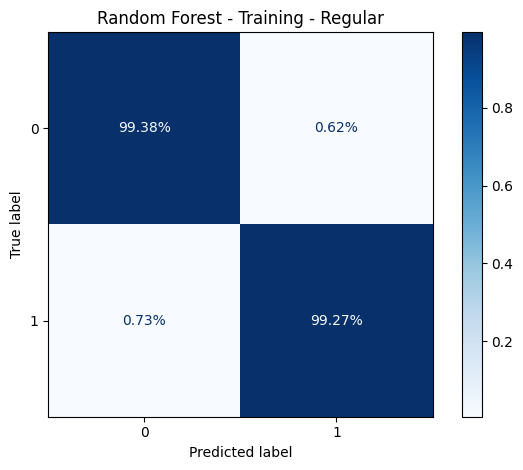

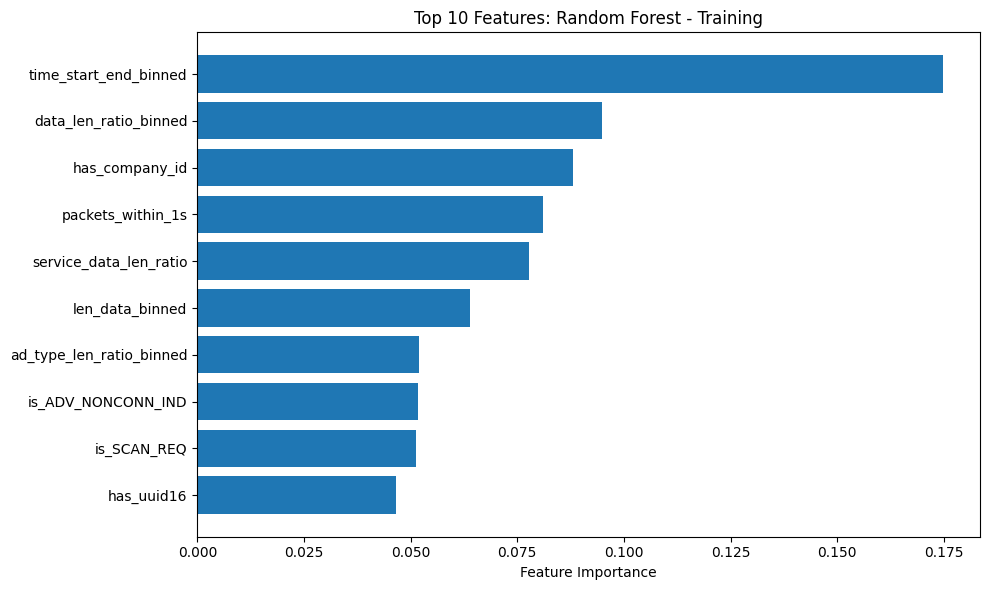

Evaluation on Test Dataset:
              precision    recall  f1-score   support

           0       0.97      0.76      0.85   1111117
           1       0.14      0.65      0.23     66079

    accuracy                           0.75   1177196
   macro avg       0.56      0.71      0.54   1177196
weighted avg       0.93      0.75      0.82   1177196



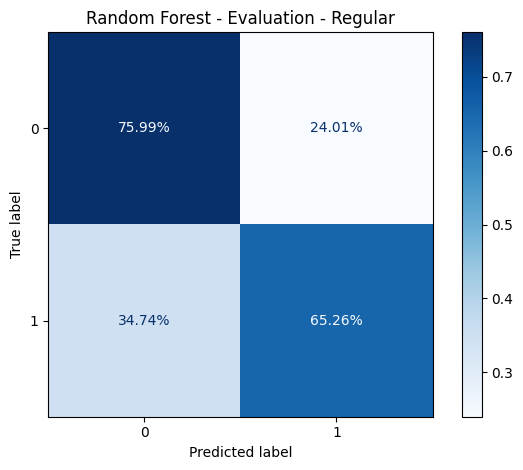

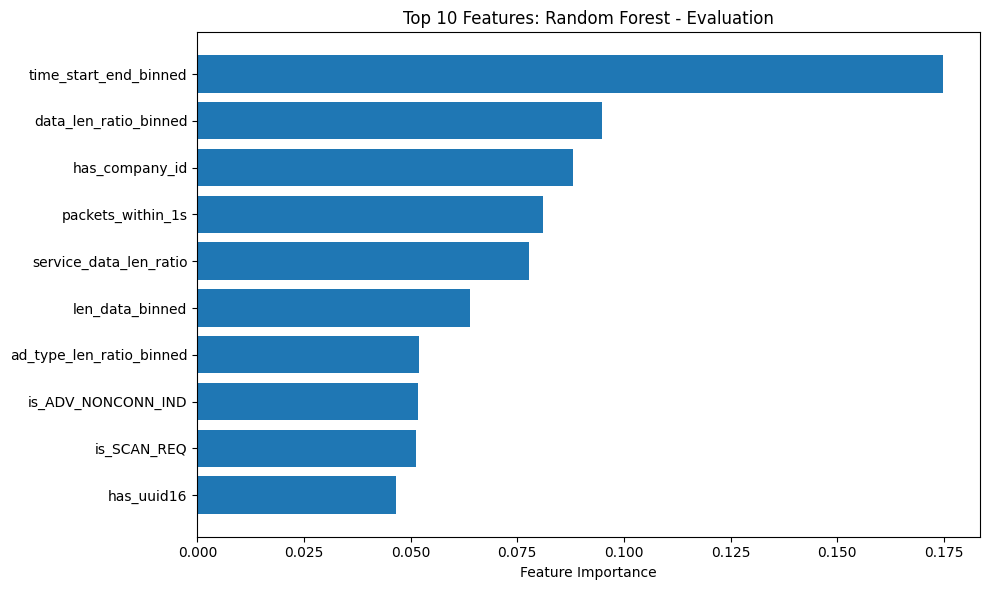


------------------------------------------------------------
STARTING MODEL: Random Forest WITH GROUPED SPLIT MODE: True AND TEST SIZE: 0.3
------------------------------------------------------------

Train Accuracy: 0.9925
Test Accuracy:  0.9927
CV Accuracy (mean ± std): 0.9860 ± 0.0067
Model Random Forest               precision    recall  f1-score   support

           0       1.00      0.99      0.99    197638
           1       0.99      0.99      0.99    158982

    accuracy                           0.99    356620
   macro avg       0.99      0.99      0.99    356620
weighted avg       0.99      0.99      0.99    356620



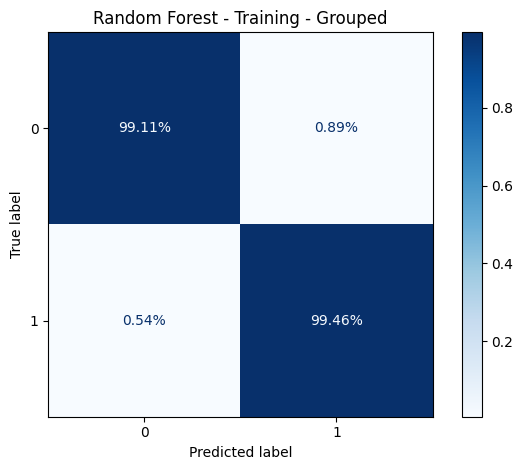

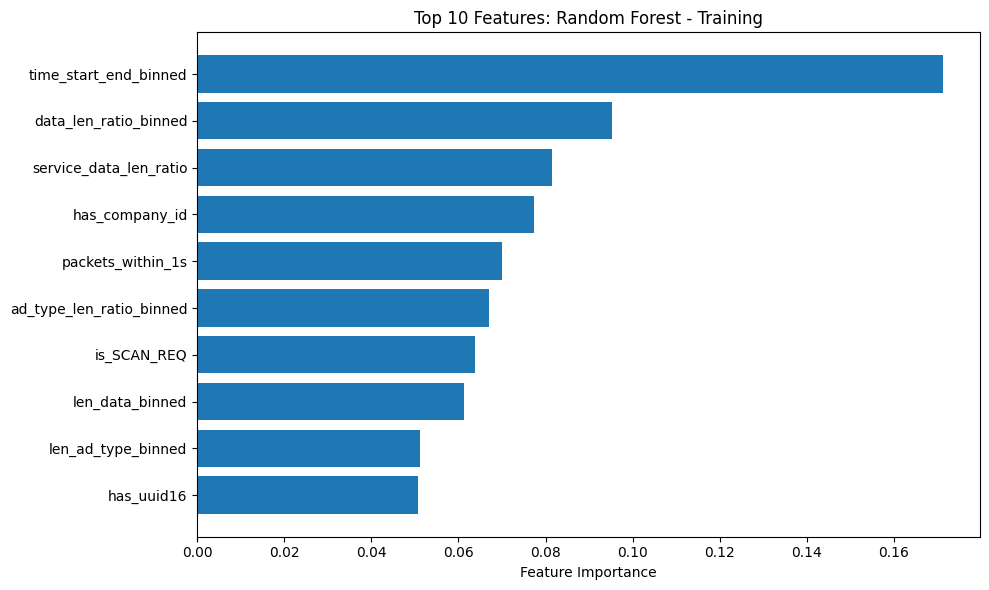

Evaluation on Test Dataset:
              precision    recall  f1-score   support

           0       0.97      0.78      0.87   1111117
           1       0.15      0.65      0.24     66079

    accuracy                           0.77   1177196
   macro avg       0.56      0.71      0.55   1177196
weighted avg       0.93      0.77      0.83   1177196



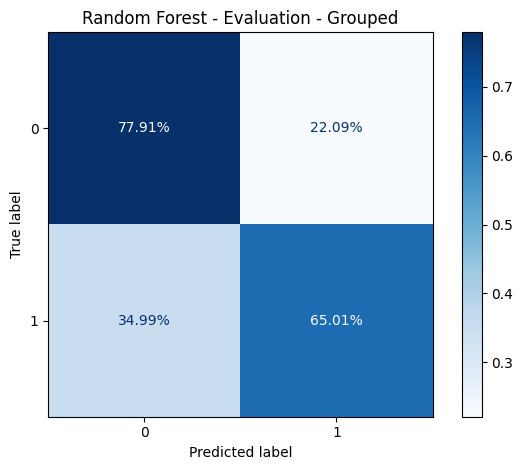

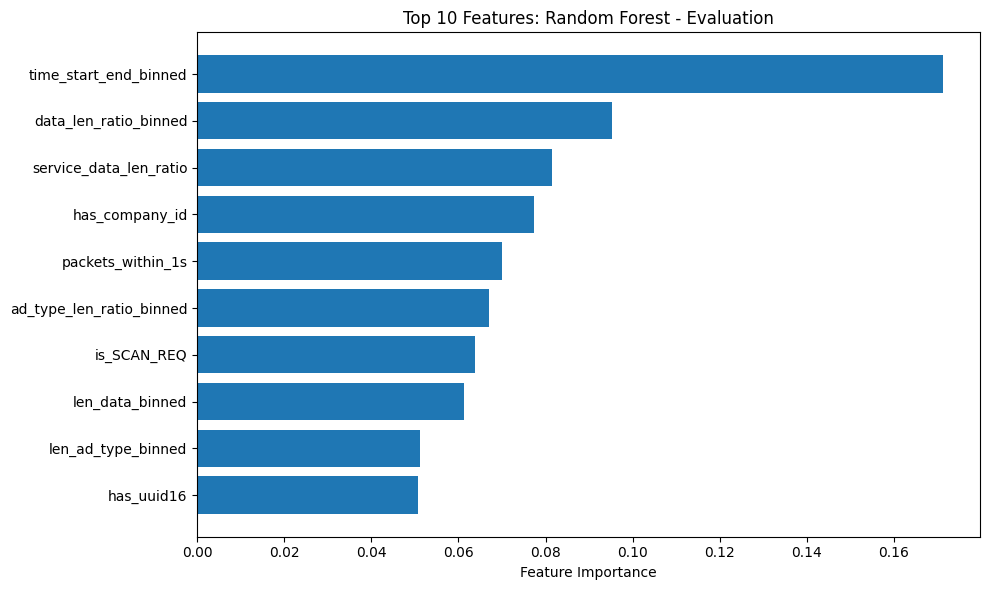


------------------------------------------------------------
STARTING MODEL: Multi-layer Perceptron WITH GROUPED SPLIT MODE: False AND TEST SIZE: 0.3
------------------------------------------------------------

Iteration 1, loss = 0.04583931
Validation score: 0.995049
Iteration 2, loss = 0.01521659
Validation score: 0.995490
Iteration 3, loss = 0.01284647
Validation score: 0.995399
Iteration 4, loss = 0.01169272
Validation score: 0.996630
Iteration 5, loss = 0.01100057
Validation score: 0.996483
Iteration 6, loss = 0.01059878
Validation score: 0.996959
Iteration 7, loss = 0.01027663
Validation score: 0.996823
Iteration 8, loss = 0.00998477
Validation score: 0.996843
Iteration 9, loss = 0.00981042
Validation score: 0.997000
Iteration 10, loss = 0.00964997
Validation score: 0.997056
Iteration 11, loss = 0.00954000
Validation score: 0.997127
Iteration 12, loss = 0.00940388
Validation score: 0.997081
Iteration 13, loss = 0.00937203
Validation score: 0.997106
Iteration 14, loss = 0.009269

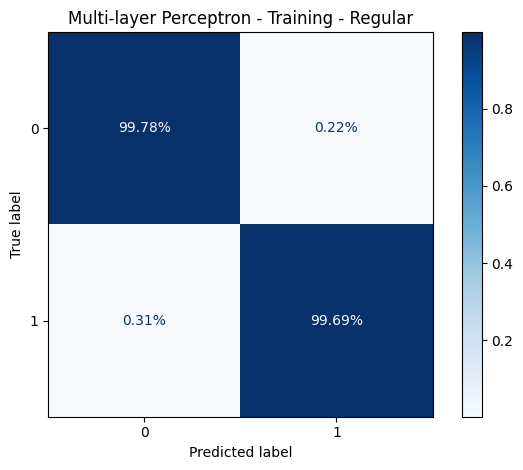


Permutation Importance:
                     Feature  Importance
20     time_start_end_binned    0.205822
6         is_ADV_NONCONN_IND    0.086397
9                is_SCAN_REQ    0.062343
26  ad_type_len_ratio_binned    0.045800
14         packets_within_1s    0.017248
0               is_broadcast    0.014955
22  delta_start_start_binned    0.012977
5                 is_ADV_IND    0.009674
23   packet_send_freq_binned    0.009313
24       time_to_next_binned    0.008610


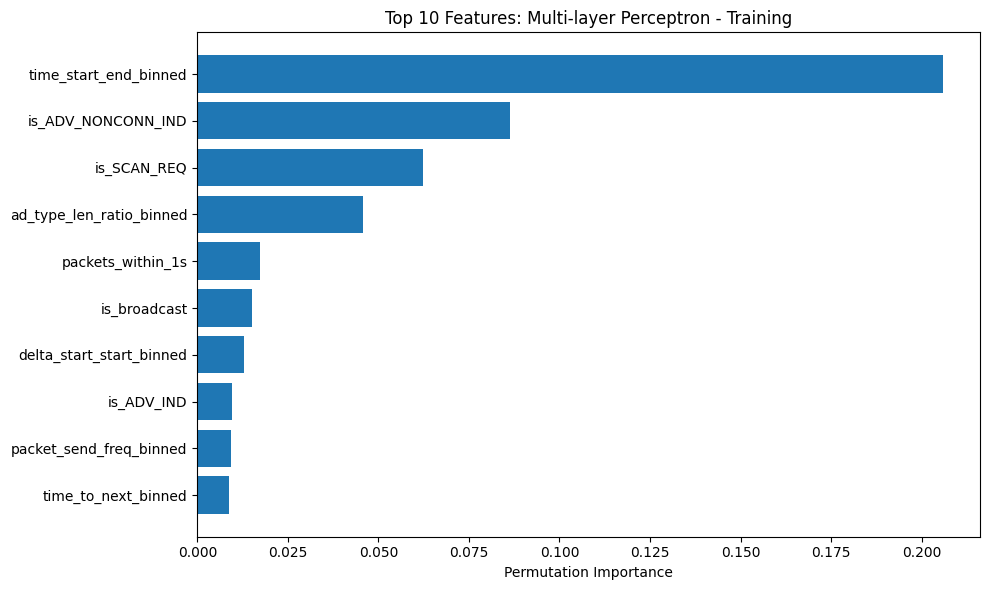

Evaluation on Test Dataset:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78   1111117
           1       0.14      0.99      0.25     66079

    accuracy                           0.66   1177196
   macro avg       0.57      0.81      0.51   1177196
weighted avg       0.95      0.66      0.75   1177196



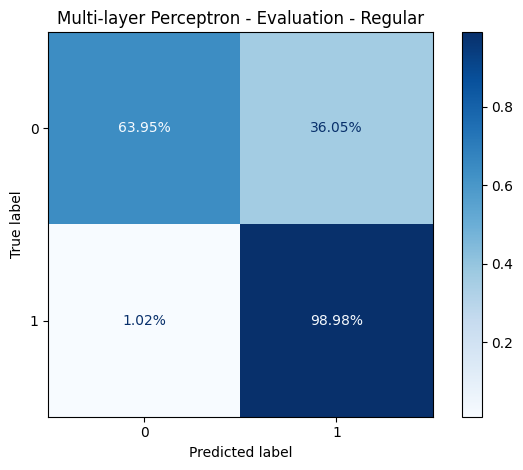


Permutation Importance:
                     Feature  Importance
20     time_start_end_binned    0.205822
6         is_ADV_NONCONN_IND    0.086397
9                is_SCAN_REQ    0.062343
26  ad_type_len_ratio_binned    0.045800
14         packets_within_1s    0.017248
0               is_broadcast    0.014955
22  delta_start_start_binned    0.012977
5                 is_ADV_IND    0.009674
23   packet_send_freq_binned    0.009313
24       time_to_next_binned    0.008610


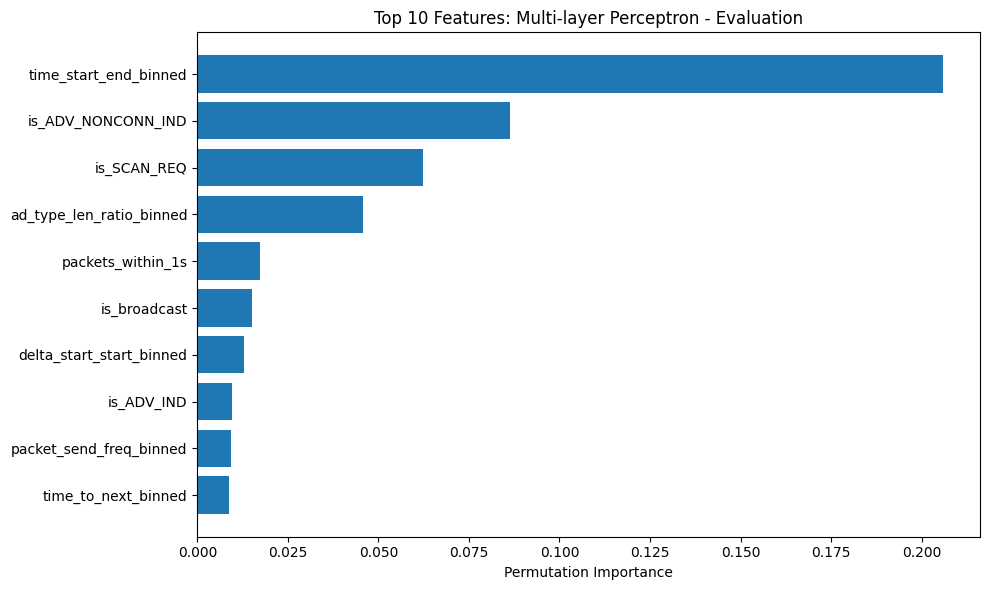


------------------------------------------------------------
STARTING MODEL: Multi-layer Perceptron WITH GROUPED SPLIT MODE: True AND TEST SIZE: 0.3
------------------------------------------------------------

Iteration 1, loss = 0.04474764
Validation score: 0.995149
Iteration 2, loss = 0.01477939
Validation score: 0.995730
Iteration 3, loss = 0.01249297
Validation score: 0.996244
Iteration 4, loss = 0.01144963
Validation score: 0.996706
Iteration 5, loss = 0.01092151
Validation score: 0.996732
Iteration 6, loss = 0.01059342
Validation score: 0.996757
Iteration 7, loss = 0.01024163
Validation score: 0.996856
Iteration 8, loss = 0.01002479
Validation score: 0.996700
Iteration 9, loss = 0.00986484
Validation score: 0.996882
Iteration 10, loss = 0.00967327
Validation score: 0.997022
Iteration 11, loss = 0.00961638
Validation score: 0.997053
Iteration 12, loss = 0.00953809
Validation score: 0.997006
Iteration 13, loss = 0.00950061
Validation score: 0.996970
Iteration 14, loss = 0.0093596

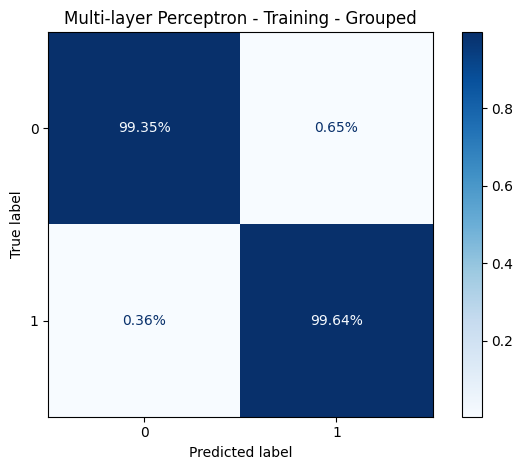


Permutation Importance:
                     Feature  Importance
20     time_start_end_binned    0.204047
6         is_ADV_NONCONN_IND    0.071061
9                is_SCAN_REQ    0.053724
14         packets_within_1s    0.035860
26  ad_type_len_ratio_binned    0.031686
0               is_broadcast    0.022340
22  delta_start_start_binned    0.016890
23   packet_send_freq_binned    0.014789
21    delta_end_start_binned    0.010729
24       time_to_next_binned    0.009429


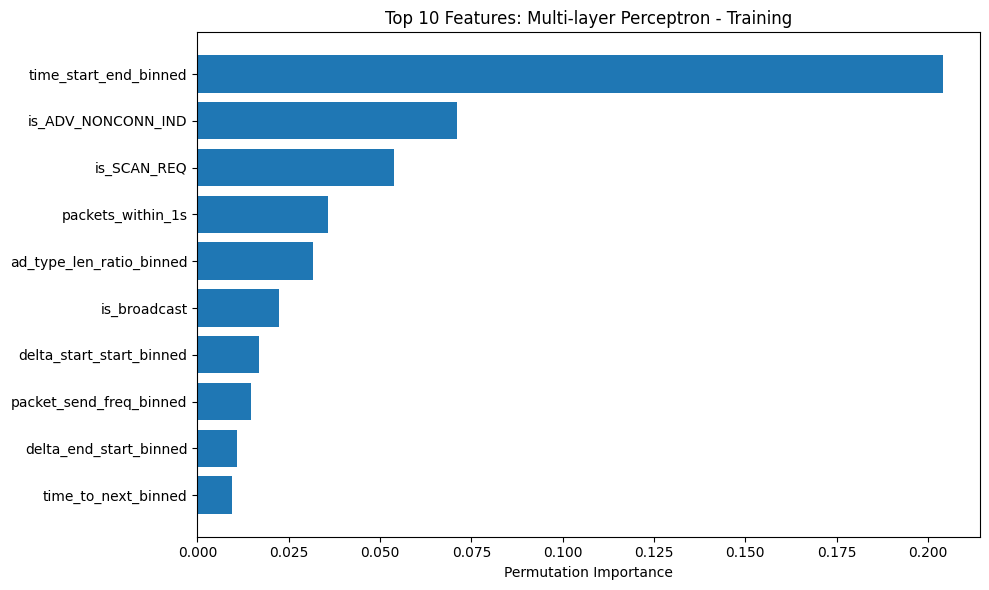

Evaluation on Test Dataset:
              precision    recall  f1-score   support

           0       1.00      0.66      0.80   1111117
           1       0.15      0.98      0.26     66079

    accuracy                           0.68   1177196
   macro avg       0.57      0.82      0.53   1177196
weighted avg       0.95      0.68      0.77   1177196



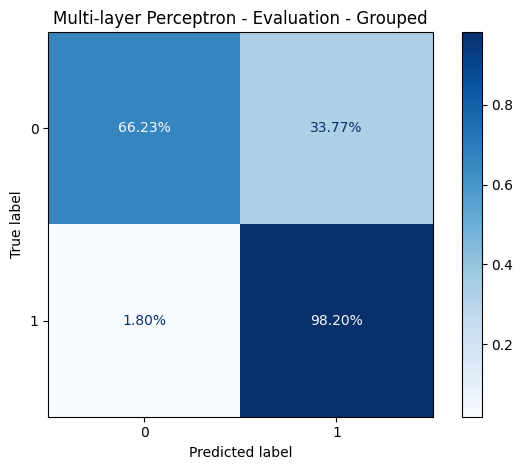


Permutation Importance:
                     Feature  Importance
20     time_start_end_binned    0.204047
6         is_ADV_NONCONN_IND    0.071061
9                is_SCAN_REQ    0.053724
14         packets_within_1s    0.035860
26  ad_type_len_ratio_binned    0.031686
0               is_broadcast    0.022340
22  delta_start_start_binned    0.016890
23   packet_send_freq_binned    0.014789
21    delta_end_start_binned    0.010729
24       time_to_next_binned    0.009429


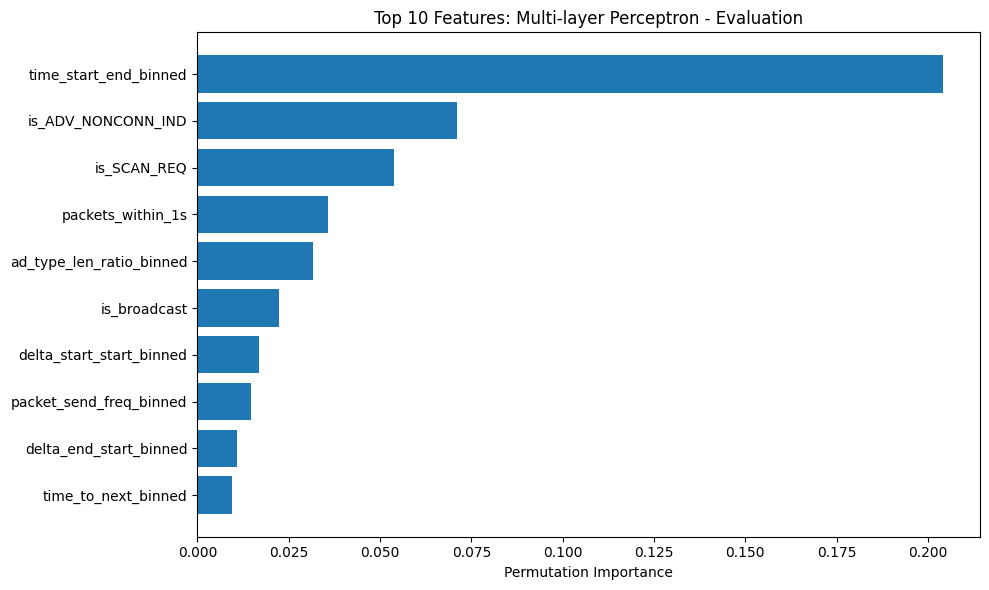


------------------------------------------------------------
STARTING MODEL: Stochastic Gradient Descent WITH GROUPED SPLIT MODE: False AND TEST SIZE: 0.3
------------------------------------------------------------

Train Accuracy: 0.8386
Test Accuracy:  0.8395
CV Accuracy (mean ± std): 0.8386 ± 0.0005
Model Stochastic Gradient Descent               precision    recall  f1-score   support

           0       0.79      0.96      0.87    181980
           1       0.94      0.69      0.80    156305

    accuracy                           0.84    338285
   macro avg       0.87      0.83      0.83    338285
weighted avg       0.86      0.84      0.84    338285



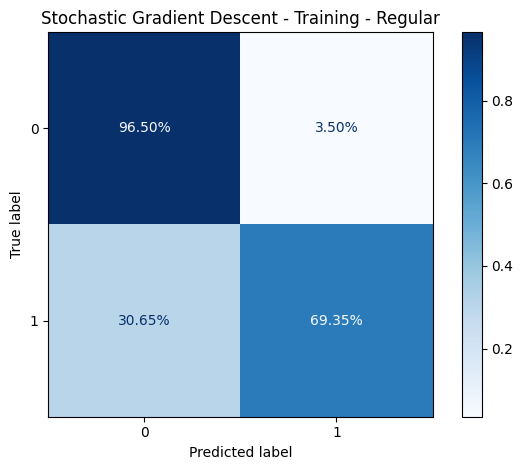


Permutation Importance:
                     Feature  Importance
13    service_data_len_ratio    0.223361
9                is_SCAN_REQ    0.150346
22  delta_start_start_binned    0.053491
21    delta_end_start_binned    0.042549
4             is_ADV_EXT_IND    0.001168
16       packets_within_25ms    0.000112
1             has_company_id    0.000043
25     data_len_ratio_binned    0.000017
20     time_start_end_binned    0.000012
6         is_ADV_NONCONN_IND    0.000009


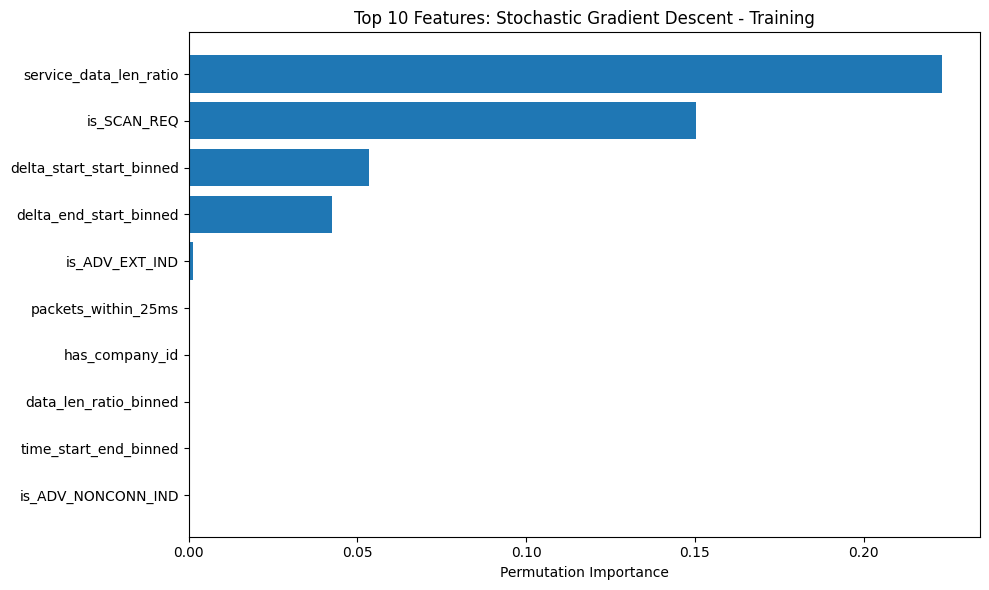

Evaluation on Test Dataset:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93   1111117
           1       0.32      0.98      0.48     66079

    accuracy                           0.88   1177196
   macro avg       0.66      0.93      0.71   1177196
weighted avg       0.96      0.88      0.91   1177196



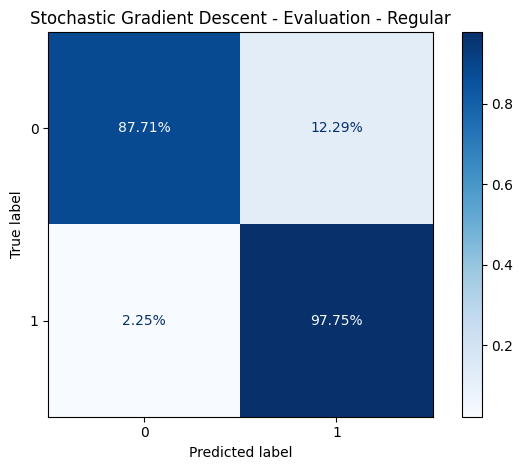


Permutation Importance:
                     Feature  Importance
13    service_data_len_ratio    0.223361
9                is_SCAN_REQ    0.150346
22  delta_start_start_binned    0.053491
21    delta_end_start_binned    0.042549
4             is_ADV_EXT_IND    0.001168
16       packets_within_25ms    0.000112
1             has_company_id    0.000043
25     data_len_ratio_binned    0.000017
20     time_start_end_binned    0.000012
6         is_ADV_NONCONN_IND    0.000009


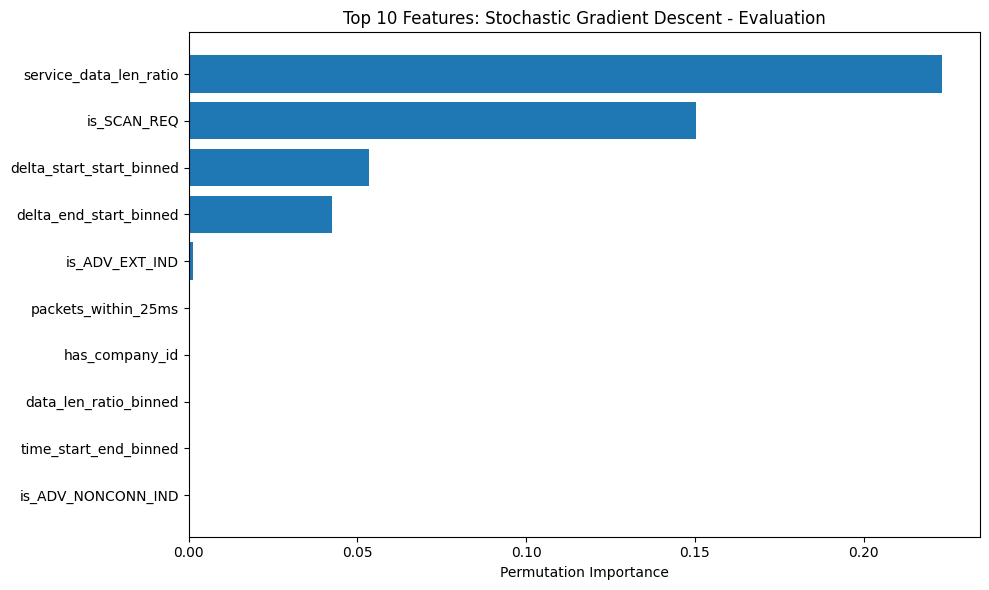


------------------------------------------------------------
STARTING MODEL: Stochastic Gradient Descent WITH GROUPED SPLIT MODE: True AND TEST SIZE: 0.3
------------------------------------------------------------

Train Accuracy: 0.8750
Test Accuracy:  0.8982
CV Accuracy (mean ± std): 0.7817 ± 0.0914
Model Stochastic Gradient Descent               precision    recall  f1-score   support

           0       0.87      0.96      0.91    197638
           1       0.94      0.82      0.88    158982

    accuracy                           0.90    356620
   macro avg       0.91      0.89      0.90    356620
weighted avg       0.90      0.90      0.90    356620



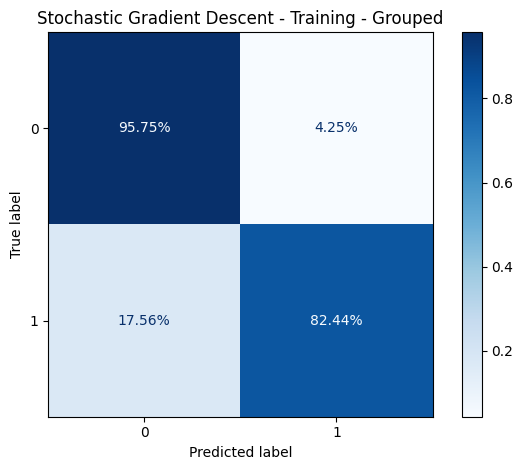


Permutation Importance:
                     Feature  Importance
13    service_data_len_ratio    0.257476
22  delta_start_start_binned    0.193632
21    delta_end_start_binned    0.180268
9                is_SCAN_REQ    0.157006
25     data_len_ratio_binned    0.018987
6         is_ADV_NONCONN_IND    0.012397
16       packets_within_25ms    0.010514
3                 has_uuid16    0.009910
1             has_company_id    0.006017
20     time_start_end_binned    0.003505


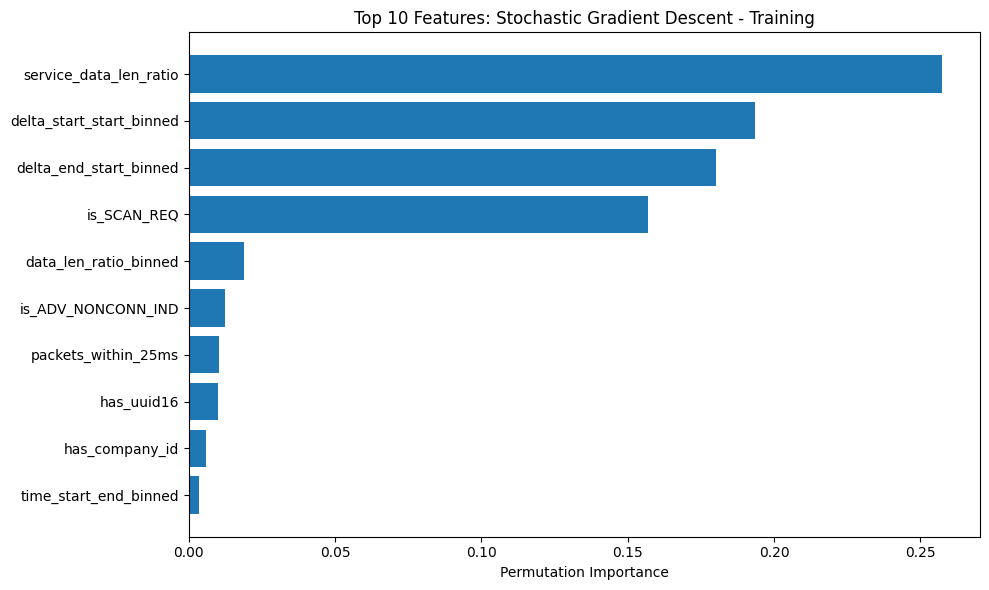

Evaluation on Test Dataset:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91   1111117
           1       0.26      0.98      0.41     66079

    accuracy                           0.84   1177196
   macro avg       0.63      0.91      0.66   1177196
weighted avg       0.96      0.84      0.88   1177196



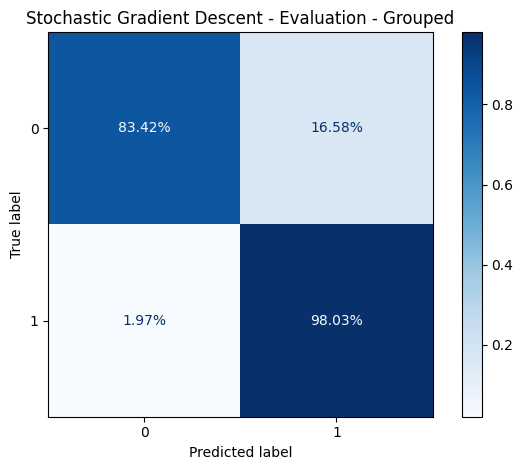


Permutation Importance:
                     Feature  Importance
13    service_data_len_ratio    0.257476
22  delta_start_start_binned    0.193632
21    delta_end_start_binned    0.180268
9                is_SCAN_REQ    0.157006
25     data_len_ratio_binned    0.018987
6         is_ADV_NONCONN_IND    0.012397
16       packets_within_25ms    0.010514
3                 has_uuid16    0.009910
1             has_company_id    0.006017
20     time_start_end_binned    0.003505


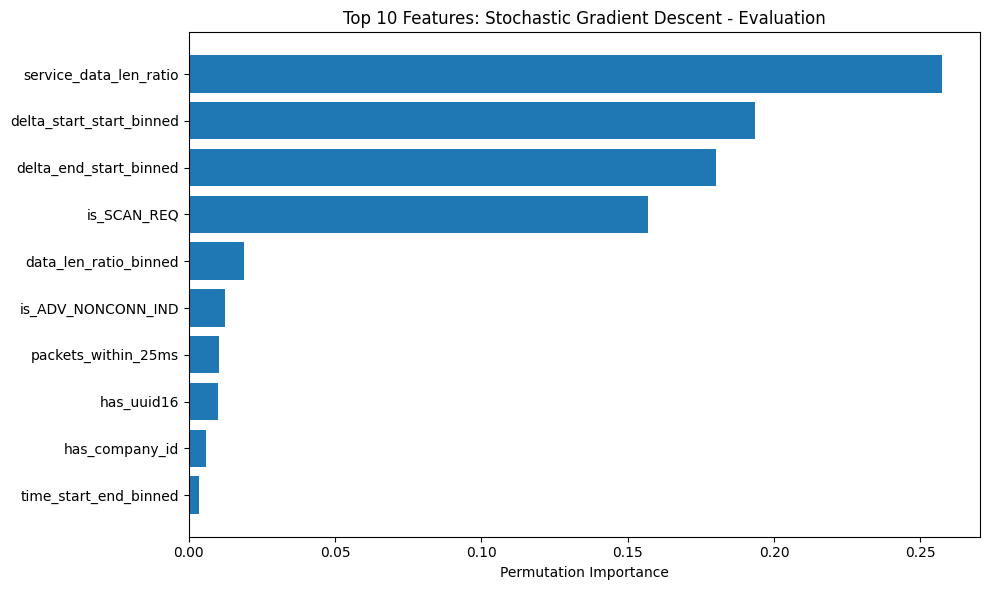

In [20]:
##############################
#        CODE FIELD 6        #
##############################

# Split-mode False tains normally, True ensures that sources are either part of the training or testing process, but not both
split_mode_grouped = [False, True]

# Define the datasets to train and evalue on (usually: train_df_binned_large_balanced and eval_df_uni_binned_balanced)
df_to_train = train_df_binned_large_balanced
df_to_eval = eval_df_binned_balanced 

# CHANGED: Make sure the order of the columns are the same
if (df_to_train.columns != df_to_eval.columns).any():
    df_to_eval = df_to_eval[df_to_train.columns]

print(f'USING COLUMNS: {list(df_to_train.drop(columns=dropped_columns).columns)}')

# Loop over defined models - if only one model should be run, comment out the others in the code box where the models are defined
for model_name in model_dict.keys():
    # Do one run without and one with source-address-based grouping
    for split_mode in split_mode_grouped:
        model_to_run = model_dict[model_name]
        df_dropped = df_to_train.drop(columns=dropped_columns + ['group_label'])

        print(f'\n------------------------------------------------------------')
        print(f'STARTING MODEL: {model_name} WITH GROUPED SPLIT MODE: {split_mode} AND TEST SIZE: {test_param}')
        print(f'------------------------------------------------------------\n')
        
        # Split the dataset
        X_train, X_test, y_train, y_test = split_data(
            base_df = df_to_train,
            X = df_dropped,
            y = df_to_train['group_label'],
            test_size = test_param,
            split_mode_group=split_mode
        )

        # Train and fit the model
        model, y_pred = fit_and_predict_model(
            model = model_to_run,
            X_train = X_train,
            X_test = X_test,
            y_train = y_train,
            y_test = y_test
        )

        # Print classification
        print(f'Model {model_name}', classification_report(y_test, y_pred))

        # Create matrix
        create_matrix(
            model = model,
            y_test = y_test,
            y_pred = y_pred,
            model_name = model_name,
            split_mode=split_mode,
            model_type='Training',
        )

        model_feature_importance(
            model=model,
            X_test=X_test,
            y_test=y_test,
            model_name=model_name,
            model_type='Training'
        )

        evaluate_model(
            model=model,
            model_name=model_name,
            eval_df=df_to_eval,
            split_mode=split_mode,
            balance_mode=True,
        )

        model_feature_importance(
            model=model,
            X_test=X_test,
            y_test=y_test,
            model_name=model_name,
            model_type='Evaluation'
        )

## Learning Curves

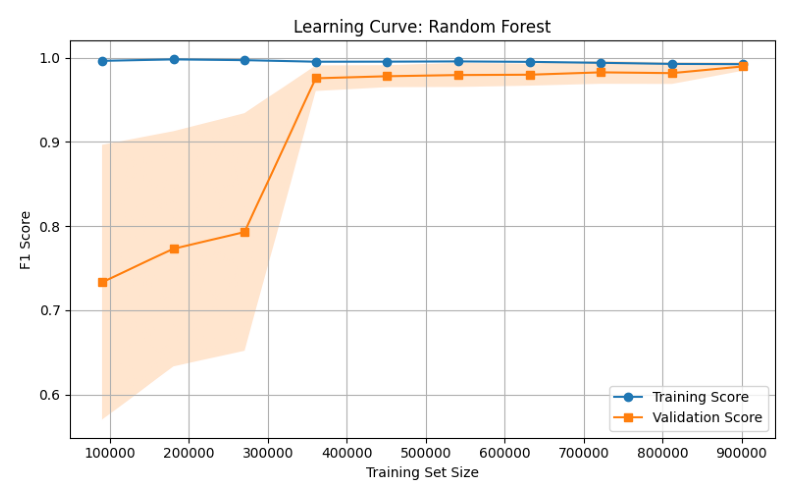

In [6]:
##############################
#        CODE FIELD 7        #
##############################

X = train_df_binned_large_balanced.drop(columns=dropped_columns + ['group_label'])
y = train_df_binned_large_balanced['group_label']

# Create learning curve including cross-validation
train_sizes, train_scores, val_scores = learning_curve(
    estimator=RandomForestClassifier(random_state=1, class_weight='balanced', n_estimators=50, min_samples_split=10, min_samples_leaf=3, min_weight_fraction_leaf=0.002),
    X=X,
    y=y,
    cv=5,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Compute means and std deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, val_mean, label='Validation Score', marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title(f'Learning Curve: Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

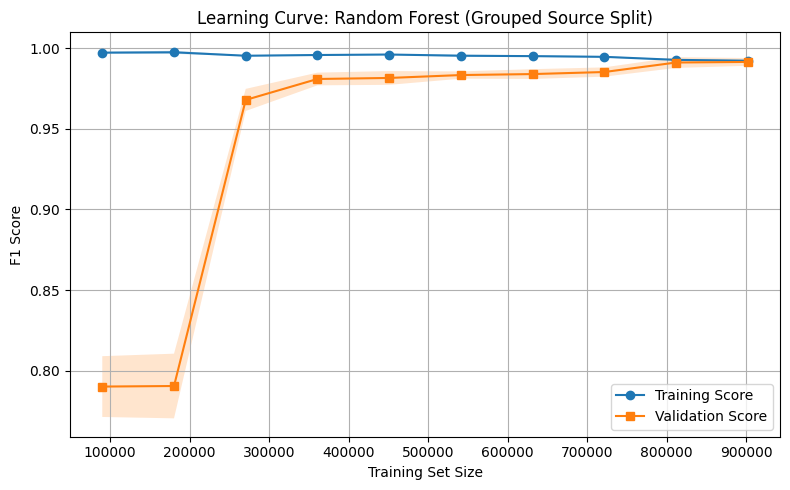

In [22]:
##############################
#        CODE FIELD 8        #
##############################

# Prepare X, y, and groups (source-based grouping)
X = train_df_binned_large_balanced.drop(columns=dropped_columns + ['group_label'])
y = train_df_binned_large_balanced['group_label']
groups = train_df_binned_large_balanced['source'].fillna('missing').astype(str)

# Group-aware cross-validation
cv = GroupKFold(n_splits=5)

train_sizes, train_scores, val_scores = learning_curve(
    estimator=RandomForestClassifier(random_state=1, class_weight='balanced', n_estimators=50, min_samples_split=10, min_samples_leaf=3, min_weight_fraction_leaf=0.002),
    X=X,
    y=y,
    groups=groups,
    cv=cv,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Compute means and std deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plotting the curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, val_mean, label='Validation Score', marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve: Random Forest (Grouped Source Split)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Unsupervised Learning

In [23]:
# Define aggregate features for unsupervised learning
# The paramter min_packets filters out any source addresses with less packets in total than the defined value
def aggregate_device_features(df, min_packets: int):
    counts = df['source'].value_counts()

    valid_sources = counts[counts >= min_packets].index
    print(f"Number of sources with packet count above {min_packets}: {len(valid_sources)}")
    df_filtered = df[df['source'].isin(valid_sources)]
                     
    grouped = df_filtered.groupby('source').agg({
        'is_ADV_EXT_IND': ['mean', 'std', 'min', 'max'],
        'is_ADV_IND': ['mean', 'std', 'min', 'max'],
        'is_ADV_NONCONN_IND': ['mean', 'std', 'min', 'max'],
        'is_ADV_SCAN_IND': ['mean', 'std', 'min', 'max'],
        'is_AUX_ADV_IND': ['mean', 'std', 'min', 'max'],
        'is_SCAN_REQ': ['mean', 'std', 'min', 'max'],
        'packets_within_1s': ['mean', 'std', 'min', 'max'],
        'packets_within_100ms': ['mean', 'std', 'min', 'max'],
        'packets_within_25ms': ['mean', 'std', 'min', 'max'],
        'packets_within_2ms': ['mean', 'std', 'min', 'max'],
        'len_ad_type_binned': ['mean', 'std', 'min', 'max'],
        'len_data_binned': ['mean', 'std', 'min', 'max'],
        'time_start_end_binned': ['mean', 'std', 'min', 'max'],
        'delta_end_start_binned': ['mean', 'std', 'min', 'max'],
        'delta_start_start_binned': ['mean', 'std', 'min', 'max'],
        'packet_send_freq_binned': ['mean', 'std', 'min', 'max'],
        'time_to_next_binned': ['mean', 'std', 'min', 'max'],
        'ad_type_len_ratio_binned': ['mean', 'std', 'min', 'max'],
        'service_data_len_ratio': ['mean', 'std', 'min', 'max'],
        'data_len_ratio_binned': ['mean', 'std', 'min', 'max'],
    })

    # Ensure the grouped columns are named nicely
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
    grouped.reset_index(inplace=True)
    return grouped

In [24]:
def run_k_means(X_scaled, cluster_size: int = 2):
    init_centroids, _ = kmeans_plusplus(X_scaled, n_clusters=cluster_size, random_state=1)
    clusterer = KMeans(n_clusters=cluster_size, init=init_centroids, n_init=1, random_state=1)
    cluster_labels = clusterer.fit_predict(X_scaled)

    return cluster_labels

def run_birch(X_scaled):
    birch_clusterer = Birch(n_clusters=2)
    cluster_labels = birch_clusterer.fit_predict(X_scaled)

    return cluster_labels

def run_bk_means(X_scaled):
    clusterer = BisectingKMeans(n_clusters=2, random_state=1)
    cluster_labels = clusterer.fit_predict(X_scaled)

    return cluster_labels

In [25]:
def evaluate_metrics(y_true, model_result, num: int):
    ari = adjusted_rand_score(y_true, model_result) # similarity of the two assignments
    homogeneity = metrics.homogeneity_score(y_true, model_result) # each cluster contains only members of a single class
    completeness = metrics.completeness_score(y_true, model_result) # all members of a given class are assigned to the same cluster
    v_score = metrics.v_measure_score(y_true, model_result) # The V-measure is actually equivalent to the mutual information
    print(f'EVAL OF SOURCES WITH AT LEAST: {num} PACKETS') 
    print(f'ARI: {ari:.4f}')
    print(f'HOMOGENEITY: {homogeneity:.4f}')
    print(f'COMPLETENESS: {completeness:.4f}')
    print(f'V SCORE: {v_score:.4f}\n')

    return ari, homogeneity, completeness, v_score

In [26]:
##############################
#        CODE FIELD 9        #
##############################

# Define dictionaries to keep track of the best performing paramteres
max_dict_k_means = {'max_ari': 0, 'max_ari_num': 0, 'max_ari_cluster': 0, 'max_v_score': 0, 'max_v_score_num': 0, 'max_v_score_cluster': 0}
max_dict_birch = {'max_ari': 0, 'max_ari_num': 0, 'max_v_score': 0, 'max_v_score_num': 0}
max_dict_bk_means = {'max_ari': 0, 'max_ari_num': 0, 'max_v_score': 0, 'max_v_score_num': 0}

# Choose the model to run: kmeans, birch, bk_means
# ADJUST:
algorithm_to_run = 'kmeans' # kmeans, birch, bk_means

# Use the loop below to find the best-performing numbers
# Use the specific number below to run the best version ([36] for kmeans, [42] for birch and [38] for BisectingKMeans)
# Using only the best-performing number ensures the parameters for plotting later are set correctly
# ADJUST:
for num in [36]:
    agg_df = aggregate_device_features(eval_df_binned_balanced, num)

    label_lookup = eval_df_binned_balanced[['source', 'group_label']].drop_duplicates()
    agg_df = agg_df.merge(label_lookup, on='source', how='left')

    X = agg_df.drop(columns=['source', 'group_label'])
    print(f'Length: {len(X)}', f'Num: {num}')

    y_true = agg_df['group_label'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    if algorithm_to_run == 'kmeans' or algorithm_to_run == 'all':
        # For KMeans, try cluster sizes 2 to 10 per num
        for cluster_size in range(2, 11):
            k_means_labels = run_k_means(X_scaled, cluster_size)
            k_means_ari, k_means_homogeneity, k_means_completeness, k_means_v_score = evaluate_metrics(y_true, k_means_labels, num)

            if k_means_ari > float(max_dict_k_means['max_ari']):
                max_dict_k_means['max_ari'] = f'{k_means_ari:.4f}'
                max_dict_k_means['max_ari_num'] = num
                max_dict_k_means['max_ari_cluster'] = cluster_size
            if k_means_v_score > float(max_dict_k_means['max_v_score']):
                max_dict_k_means['max_v_score'] = f'{k_means_v_score:.4f}'
                max_dict_k_means['max_v_score_num'] = num
                max_dict_k_means['max_v_score_cluster'] = cluster_size

    if algorithm_to_run == 'birch' or algorithm_to_run == 'all':
        # Run Birch model
        birch_labels = run_birch(X_scaled=X_scaled)
        birch_ari, birch_homogeneity, birch_completeness, birch_v_score = evaluate_metrics(y_true, birch_labels, num)

        if birch_ari > float(max_dict_birch['max_ari']):
            max_dict_birch['max_ari'] = f'{birch_ari:.4f}'
            max_dict_birch['max_ari_num'] = num
        if birch_v_score > float(max_dict_birch['max_v_score']):
            max_dict_birch['max_v_score'] = f'{birch_v_score:.4f}'
            max_dict_birch['max_v_score_num'] = num
    
    if algorithm_to_run == 'bk_means' or algorithm_to_run == 'all':
        # Run BisectingKMeans model
        bk_means_labels = run_bk_means(X_scaled=X_scaled)
        bk_means_ari, bk_means_homogeneity, bk_means_completeness, bk_means_v_score = evaluate_metrics(y_true, bk_means_labels, num)

        if bk_means_ari > float(max_dict_bk_means['max_ari']):
            max_dict_bk_means['max_ari'] = f'{bk_means_ari:.4f}'
            max_dict_bk_means['max_ari_num'] = num
        if bk_means_v_score > float(max_dict_bk_means['max_v_score']):
            max_dict_bk_means['max_v_score'] = f'{bk_means_v_score:.4f}'
            max_dict_bk_means['max_v_score_num'] = num
print('------------------------------------------------')
print(f'FINAL_DICT K_MEANS: {max_dict_k_means}')
print(f'FINAL_DICT BIRCH: {max_dict_birch}')
print(f'FINAL_DICT BK_MEANS: {max_dict_bk_means}')

Number of sources with packet count above 36: 2331
Length: 2331 Num: 36
EVAL OF SOURCES WITH AT LEAST: 36 PACKETS
ARI: 0.4121
HOMOGENEITY: 0.2099
COMPLETENESS: 0.5343
V SCORE: 0.3014

EVAL OF SOURCES WITH AT LEAST: 36 PACKETS
ARI: 0.0301
HOMOGENEITY: 0.0534
COMPLETENESS: 0.0110
V SCORE: 0.0183

EVAL OF SOURCES WITH AT LEAST: 36 PACKETS
ARI: 0.0090
HOMOGENEITY: 0.0780
COMPLETENESS: 0.0099
V SCORE: 0.0175

EVAL OF SOURCES WITH AT LEAST: 36 PACKETS
ARI: 0.0089
HOMOGENEITY: 0.0781
COMPLETENESS: 0.0099
V SCORE: 0.0175

EVAL OF SOURCES WITH AT LEAST: 36 PACKETS
ARI: -0.0015
HOMOGENEITY: 0.1071
COMPLETENESS: 0.0110
V SCORE: 0.0200

EVAL OF SOURCES WITH AT LEAST: 36 PACKETS
ARI: 0.0082
HOMOGENEITY: 0.2807
COMPLETENESS: 0.0281
V SCORE: 0.0510

EVAL OF SOURCES WITH AT LEAST: 36 PACKETS
ARI: 0.0182
HOMOGENEITY: 0.3043
COMPLETENESS: 0.0304
V SCORE: 0.0553

EVAL OF SOURCES WITH AT LEAST: 36 PACKETS
ARI: 0.0182
HOMOGENEITY: 0.3045
COMPLETENESS: 0.0304
V SCORE: 0.0553

EVAL OF SOURCES WITH AT LEAST: 

In [27]:
##############################
#        CODE FIELD 10       #
##############################

# Adjust labels to match algorithm to analyze
# Also, make sure to run the model in the previous section with only ONE specific num defined
# (i.e. use the commented row 'for num in [x]')
# Otherwise the parameters below will point to the false values
# ADJUST: 
current_labels = k_means_labels # k_means_labels, birch_labels, bk_means_labels
current_algorithm = 'kmeans' # kmeans, birch, bk_means

df_to_analyze = pd.DataFrame({
    'source': agg_df['source'],
    'group_label': agg_df['group_label'],
    'kmeans_label': current_labels
})

df_to_analyze['kmeans_label_named'] = ['Group Label B' if label == 0 else 'Group Label A' for label in current_labels]
device_labels_unique = eval_df_binned_balanced[['source', 'labelled_device', 'company_id']].drop_duplicates()
final_df = df_to_analyze.merge(device_labels_unique, on='source', how='left').drop_duplicates(subset='source')

# Filter rows where group_label matches the algorithm label
# Also adjust the comparison logic based on the algorithm, example:
# For KMeans the label is inversed (i.e. target group = 0), for Birch the label matches (i.e. target group = 1)
if current_algorithm in ['kmeans', 'bk_means']:
    mismatching_rows = final_df[final_df['group_label'] == final_df['kmeans_label']]
    matching_rows = final_df[final_df['group_label'] != final_df['kmeans_label']]
else:
    mismatching_rows = final_df[final_df['group_label'] != final_df['kmeans_label']]
    matching_rows = final_df[final_df['group_label'] == final_df['kmeans_label']]

# Count how often each labelled_device appears in the matched rows
device_mismatch_counts_by_device = Counter(mismatching_rows['labelled_device'])
device_match_counts_by_device = Counter(matching_rows['labelled_device'])

device_mismatch_counts = Counter(zip(mismatching_rows['labelled_device'], mismatching_rows['company_id']))
device_match_counts = Counter(zip(matching_rows['labelled_device'], matching_rows['company_id']))

print(f'Length final list: {len(final_df)}')
print('---------------')
print('False labels by device: \n', device_mismatch_counts_by_device)
print('---------------')
print('Correct labels by device: \n', device_match_counts_by_device)
print('---------------')
print('False labels detailed: \n', device_mismatch_counts)
print('---------------')
print('Correct label detailed: \n', device_match_counts)

Length final list: 2331
---------------
False labels by device: 
 Counter({'empty': 450, 'Phone': 17})
---------------
Correct labels by device: 
 Counter({'empty': 1793, 'Phone': 53, 'Smart Tag': 17, 'Buds': 1})
---------------
False labels detailed: 
 Counter({('empty', 'Apple, Inc.'): 269, ('empty', 'Microsoft'): 79, ('empty', 'Undefined'): 64, ('empty', 'Unknown'): 24, ('Phone', 'Undefined'): 17, ('empty', 'Marvell Technology Group Ltd.'): 2, ('empty', 'Beats Electronics'): 2, ('empty', 'Beautiful Enterprise Co., Ltd.'): 2, ('empty', 'Ericsson AB'): 1, ('empty', 'Socket Mobile'): 1, ('empty', 'HM Electronics, Inc.'): 1, ('empty', 'Ecotest'): 1, ('empty', 'Mesh-Net Ltd'): 1, ('empty', 'Fugoo, Inc.'): 1, ('empty', 'Belkin International, Inc.'): 1, ('empty', 'Sony Corporation'): 1})
---------------
Correct label detailed: 
 Counter({('empty', 'Apple, Inc.'): 1102, ('empty', 'Undefined'): 575, ('empty', 'Microsoft'): 62, ('Phone', 'Undefined'): 50, ('empty', 'Unknown'): 21, ('Smart Tag

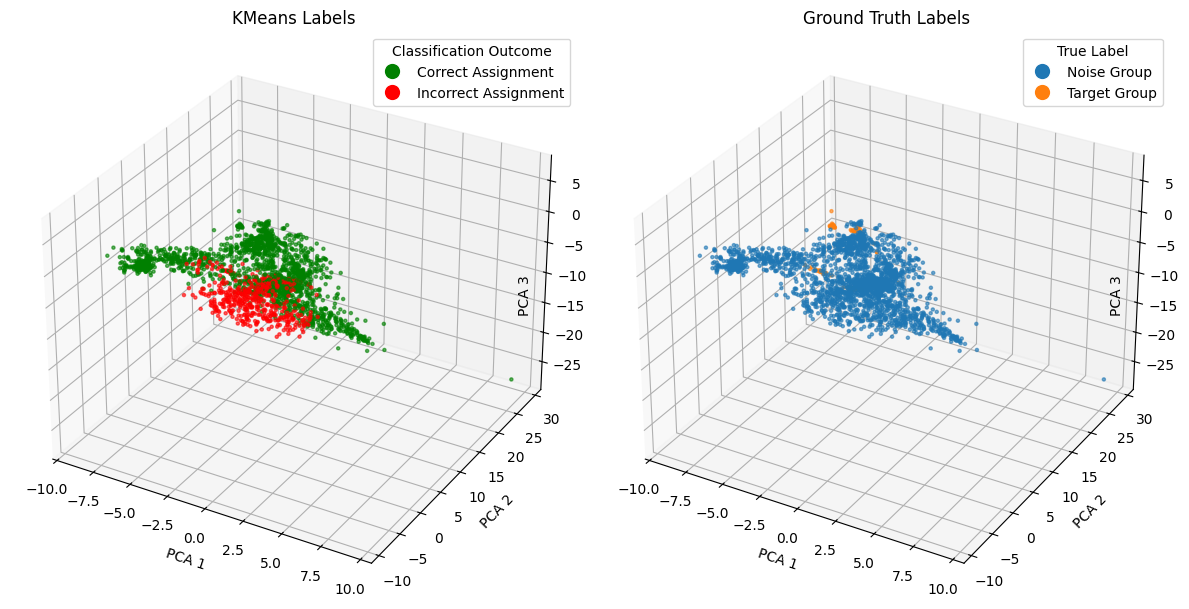

In [28]:
##############################
#       CODE FIELD 11.1      #
##############################

# Define the reduction algorithm and use the correct labels (depending on which model to analyze)
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X_scaled)
# ADJUST:
labels_to_plot = k_means_labels # k_means_labels, birch_labels, bk_means_labels

# Change labels here to the algorithm you are trying to plot
colors = []
for km, yt in zip(labels_to_plot, y_true):
    # Depending on the algorithm, the labels will either match (i.e. target = 1) or not (target = 0)
    # The problem is that you can't control which cluster is assigned which label
    # Therefore, change the logic statement based on the current algorithm
    if current_algorithm in ['kmeans', 'bk_means']:
        if km != yt:
            colors.append('green')
        elif km == yt:
            colors.append('red')
    else:
        if km != yt:
            colors.append('red')
        elif km == yt:
            colors.append('green')


y_true_named = ['Noise Group' if label == 0 else 'Target Group' for label in y_true]
fig = plt.figure(figsize=(12, 6))

# Left Graph
# Adjust the labels and title according to the current model you are running
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=colors, alpha=0.6, s=5)
# ADJUST:
ax1.set_title('KMeans Labels') # KMeans, Birch, BisectingKMeans
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Correct Assignment', markerfacecolor='green', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Incorrect Assignment', markerfacecolor='red', markersize=12),
]
ax1.legend(handles=legend_elements, title='Classification Outcome')

# Right Graph
# Adjust the labels and title according to the current model you are running
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
group_colors = {
    'Noise Group': 'tab:blue',  
    'Target Group': 'tab:orange' 
}
for group in set(y_true_named):
    idx = [i for i, label in enumerate(y_true_named) if label == group]
    ax2.scatter(X_3d[idx, 0], X_3d[idx, 1], X_3d[idx, 2], label=group, alpha=0.6, s=5, color=group_colors[group]) # adjust size depending on density 
ax2.set_title('Ground Truth Labels')
ax2.set_xlabel('PCA 1')
ax2.set_ylabel('PCA 2')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Noise Group', markerfacecolor='C0', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='Target Group', markerfacecolor='C1', markersize=12),
]
ax2.legend(handles=legend_elements, title='True Label', fontsize=10, title_fontsize=10)

for ax in (ax1, ax2):
    ax.text2D(
        0.92, 0.5, "PCA 3",
        transform=ax.transAxes,
        rotation=90,
        va="bottom",
        ha="right"
    )

plt.tight_layout()
plt.show()


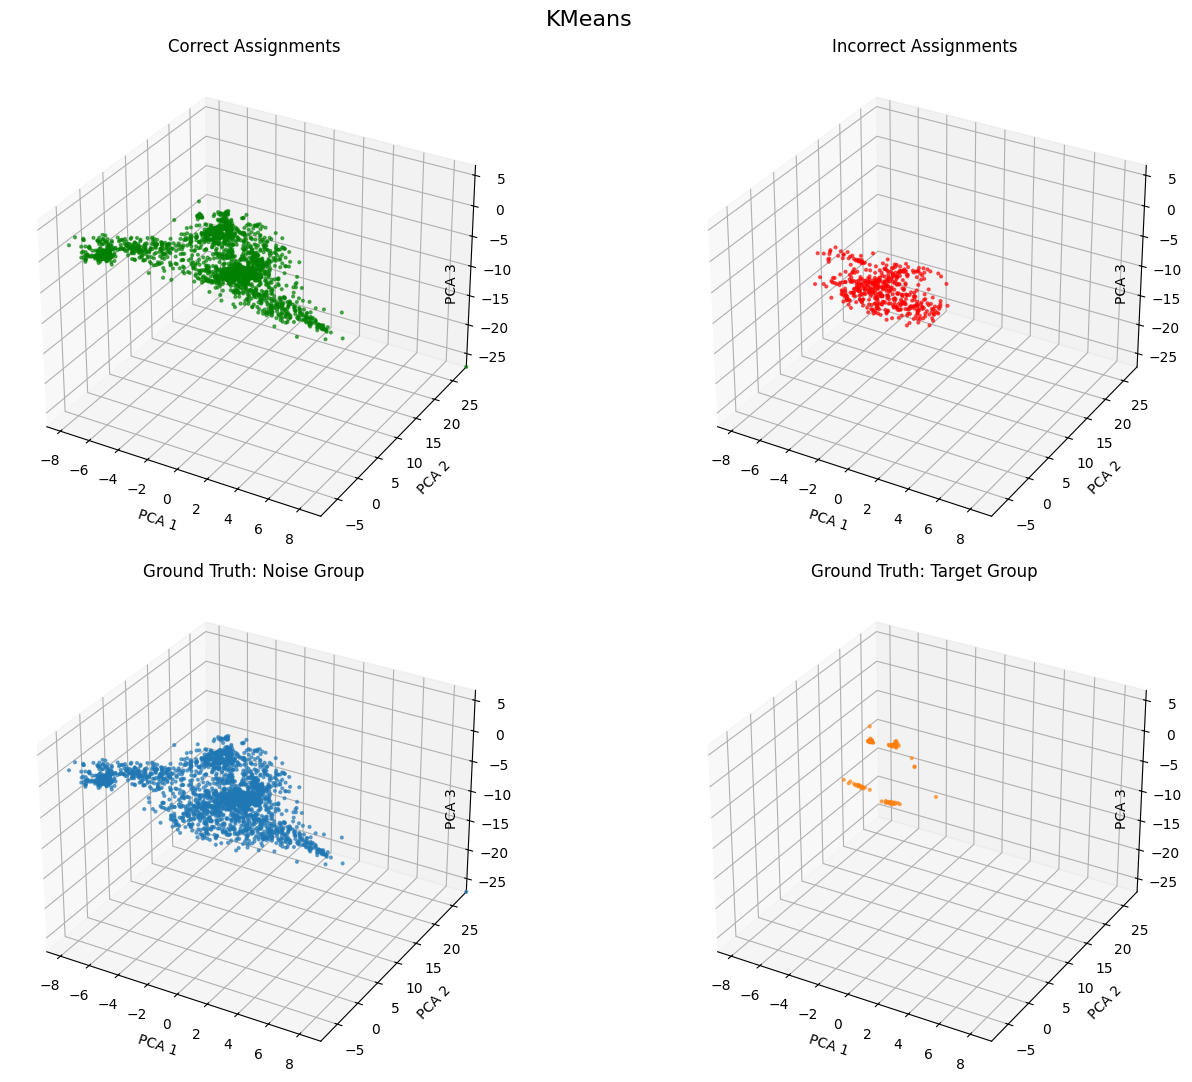

In [ ]:
#####################################################
#       CODE FIELD 11.2 - for overlapping data      #
#####################################################

# Define the reduction algorithm
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X_scaled)

# Select the labeling algorithm you want to visualize
# ADJUST
labels_to_plot = k_means_labels # k_means_labels, birch_labels, bk_means_labels

# -------------------------------------------------------
# Determine correct/incorrect assignments for plotting
# -------------------------------------------------------
correct_idx = []
incorrect_idx = []

for i, (pred, truth) in enumerate(zip(labels_to_plot, y_true)):
    # Resolve which numeric label corresponds to positive/negative
    if current_algorithm in ['kmeans', 'bk_means']:
        if pred != truth:
            correct_idx.append(i)
        else:
            incorrect_idx.append(i)
    else:
        # Birch output label mapping differs
        if pred == truth:
            correct_idx.append(i)
        else:
            incorrect_idx.append(i)

# -------------------------------------------------------
# Ground-Truth Groups
# -------------------------------------------------------
noise_idx = [i for i, y in enumerate(y_true) if y == 0]
device_idx = [i for i, y in enumerate(y_true) if y == 1]

# -------------------------------------------------------
# Plot Setup — 2×2 Grid
# -------------------------------------------------------
fig = plt.figure(figsize=(15, 11))

# Common axis limits
x_min, x_max = X_3d[:, 0].min(), X_3d[:, 0].max()
y_min, y_max = X_3d[:, 1].min(), X_3d[:, 1].max()
z_min, z_max = X_3d[:, 2].min(), X_3d[:, 2].max()

# ============================================
# Plot 1 — Correct Assignments
# ============================================
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.scatter(
    X_3d[correct_idx, 0],
    X_3d[correct_idx, 1],
    X_3d[correct_idx, 2],
    c='green',
    s=4,
    alpha=0.6
)
ax1.set_title("Correct Assignments", fontsize=12)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")
ax1.set_zlabel("PCA 3", fontsize=10)

# ============================================
# Plot 2 — Incorrect Assignments
# ============================================
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.scatter(
    X_3d[incorrect_idx, 0],
    X_3d[incorrect_idx, 1],
    X_3d[incorrect_idx, 2],
    c='red',
    s=4,
    alpha=0.6
)
ax2.set_title("Incorrect Assignments", fontsize=12)
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.set_xlabel("PCA 1")
ax2.set_ylabel("PCA 2")
ax2.set_zlabel("PCA 3", fontsize=10)

# ============================================
# Plot 3 — Ground Truth Noise Group
# ============================================
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.scatter(
    X_3d[noise_idx, 0],
    X_3d[noise_idx, 1],
    X_3d[noise_idx, 2],
    c='tab:blue',
    s=4,
    alpha=0.6
)
ax3.set_title("Ground Truth: Noise Group", fontsize=12)
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)
ax3.set_zlim(z_min, z_max)
ax3.set_xlabel("PCA 1")
ax3.set_ylabel("PCA 2")
ax3.set_zlabel("PCA 3", fontsize=10)

# ============================================
# Plot 4 — Ground Truth Target Group
# ============================================
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.scatter(
    X_3d[device_idx, 0],
    X_3d[device_idx, 1],
    X_3d[device_idx, 2],
    c='tab:orange',
    s=4,
    alpha=0.6
)
ax4.set_title("Ground Truth: Target Group", fontsize=12)
ax4.set_xlim(x_min, x_max)
ax4.set_ylim(y_min, y_max)
ax4.set_zlim(z_min, z_max)
ax4.set_xlabel("PCA 1")
ax4.set_ylabel("PCA 2")
ax4.set_zlabel("PCA 3", fontsize=10, labelpad=20)

for ax in (ax1, ax2, ax3, ax4):
    ax.set_zlabel("")
    ax.text2D(
        0.92, 0.5, "PCA 3",
        transform=ax.transAxes,
        rotation=90,
        va="bottom",
        ha="right"
    )

fig.suptitle("KMeans", fontsize="16") 
plt.tight_layout()    
plt.show()


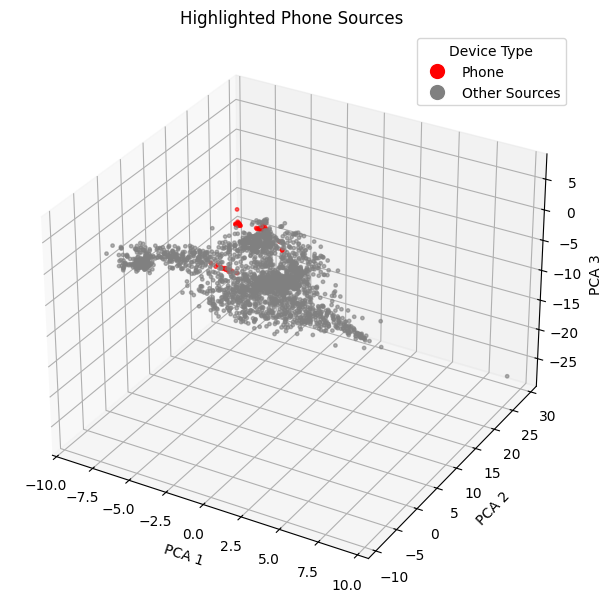

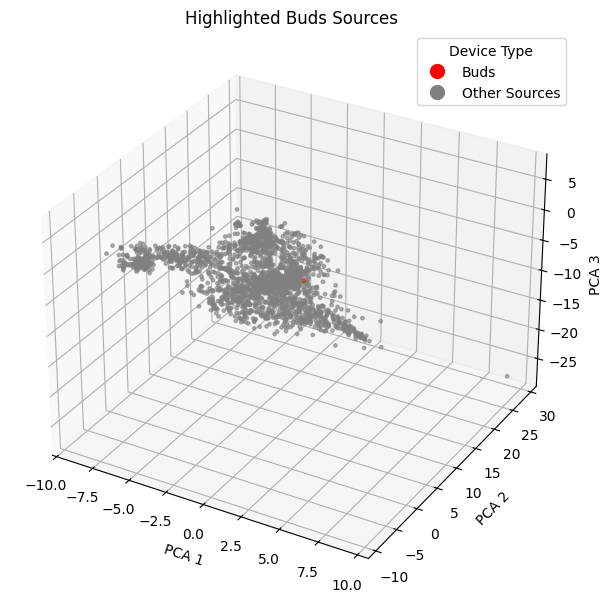

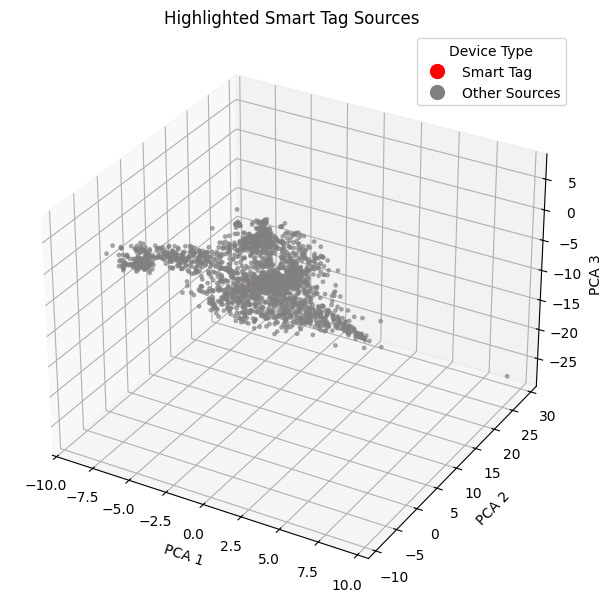

In [32]:
##############################
#        CODE FIELD 12       #
##############################

# PCA projection of the scaled data
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X_scaled)

for device in target_list: 

    # Map the source and labelled_device column onto the evaluation dataset
    mapped_df = agg_df[['source']].copy()
    mapped_df['labelled_device'] = mapped_df['source'].map(
        eval_df_binned_balanced.drop_duplicates('source').set_index('source')['labelled_device']
    )

    # Assign colors: red for the device, gray for all others
    colors = ['red' if device_to_show == device else 'gray' for device_to_show in mapped_df['labelled_device']]

    # Create group labels for ground truth plot
    y_true_named = ['Noise Group' if label == 0 else 'Target Group' for label in y_true]

    # Plotting the graph
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=colors, alpha=0.6, s=6)
    ax1.set_title(f'Highlighted {device} Sources')
    ax1.set_xlabel('PCA 1')
    ax1.set_ylabel('PCA 2')

    # Legend for device types
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=device, markerfacecolor='Red', markersize=12),
        Line2D([0], [0], marker='o', color='w', label='Other Sources', markerfacecolor='gray', markersize=12),
    ]
    ax1.legend(handles=legend_elements, title='Device Type')

    # Adjust position for each algorithm
    ax1.text2D(
        x=0.17,  
        y=0.6, 
        s="PCA 3", 
        transform=ax.transAxes,
        rotation=90
    )

    plt.tight_layout()
    plt.show()

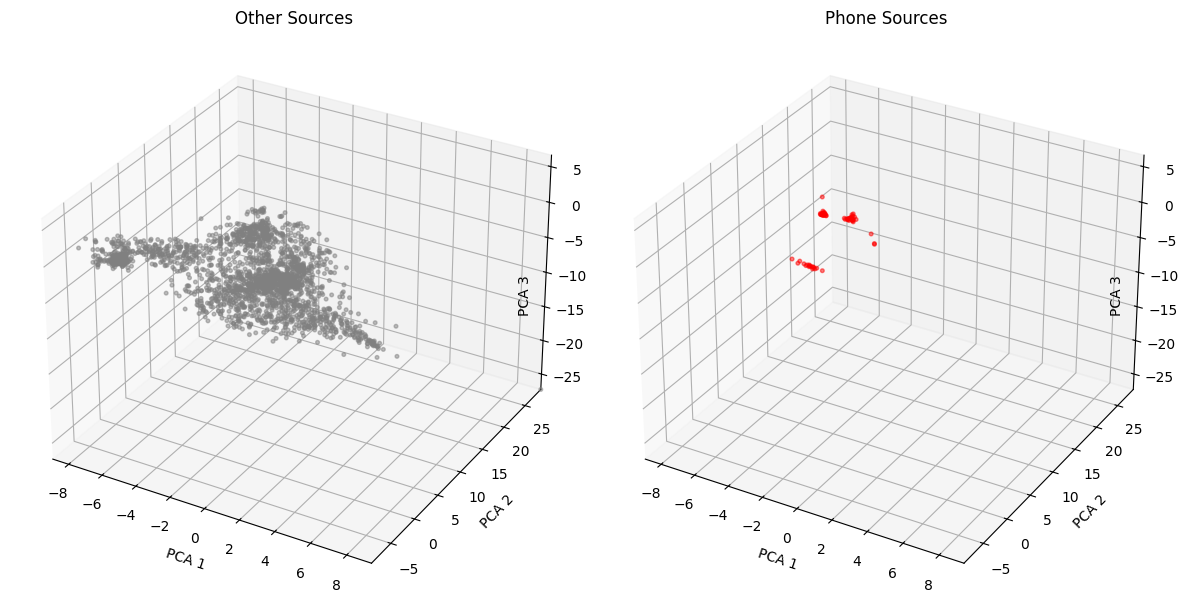

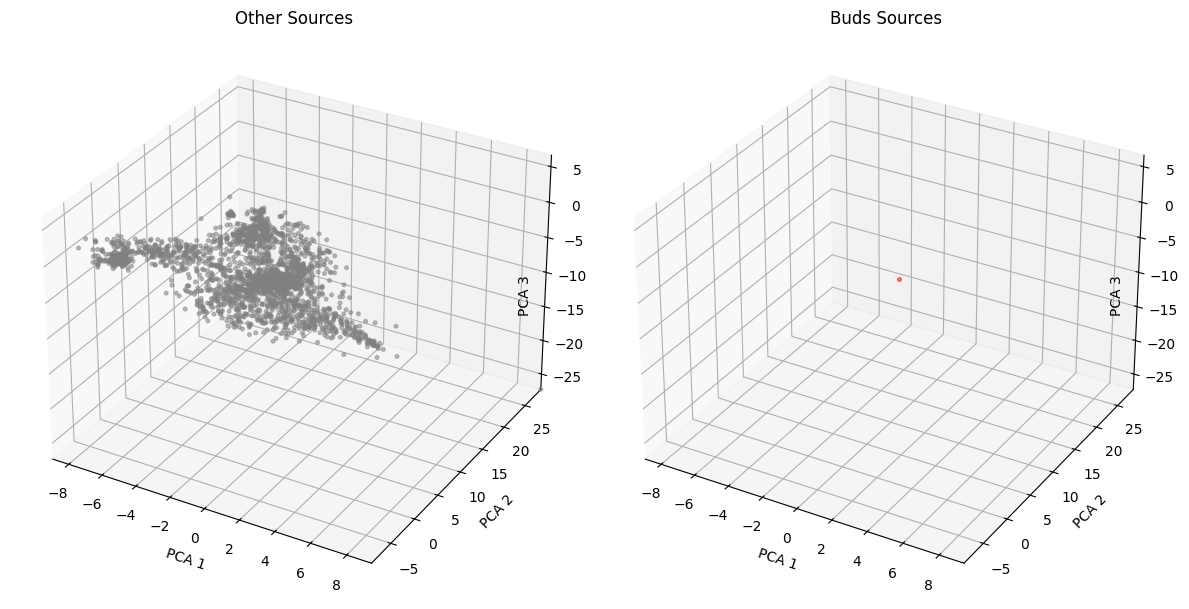

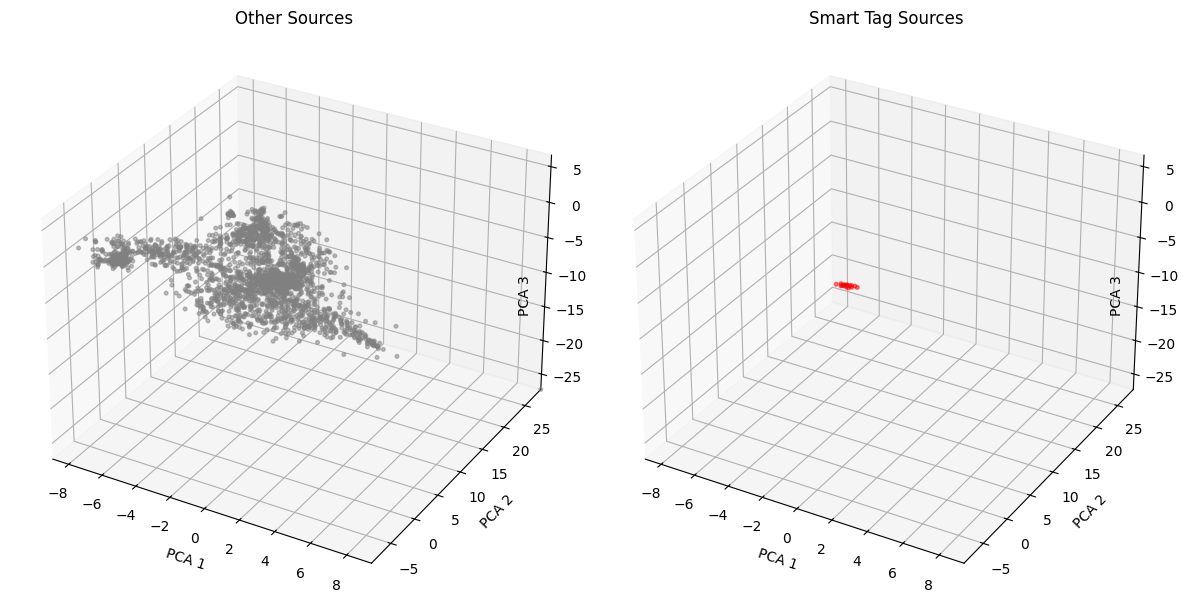

In [49]:
####################################################
#      CODE FIELD 12.2 - for overlapping data      #
####################################################

# PCA projection of the scaled data
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X_scaled)

# get axis limits
x_min, x_max = X_3d[:, 0].min(), X_3d[:, 0].max()
y_min, y_max = X_3d[:, 1].min(), X_3d[:, 1].max()
z_min, z_max = X_3d[:, 2].min(), X_3d[:, 2].max()

for device in target_list:
    # Map the source and labelled_device columns onto the evaluation dataset
    mapped_df = agg_df[['source']].copy()
    mapped_df['labelled_device'] = mapped_df['source'].map(
        eval_df_binned_balanced.drop_duplicates('source').set_index('source')['labelled_device']
    )

    # Identify indices for target group (device_to_show) and noise (all others)
    device_idx = [i for i, label in enumerate(mapped_df['labelled_device']) if label == device]
    noise_idx = [i for i, label in enumerate(mapped_df['labelled_device']) if label != device]
    
    fig = plt.figure(figsize=(12, 6))  

    # ----------------------
    # Subplot 1: Noise Group
    # ----------------------
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(X_3d[noise_idx, 0], X_3d[noise_idx, 1], X_3d[noise_idx, 2],
                c='gray', alpha=0.5, s=7)
    ax1.set_title("Other Sources")
    ax1.set_xlabel('PCA 1')
    ax1.set_ylabel('PCA 2')

    # ----------------------
    # Subplot 2: Target Group
    # ----------------------
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(X_3d[device_idx, 0], X_3d[device_idx, 1], X_3d[device_idx, 2],
                c='red', alpha=0.5, s=7)
    ax2.set_title(f"{device} Sources")
    ax2.set_xlabel('PCA 1')
    ax2.set_ylabel('PCA 2')

    for ax in (ax1, ax2):
        # set z-axis label
        ax.set_zlabel("") 
        ax.text2D(
            0.92, 0.5, "PCA 3",
            transform=ax.transAxes,
            rotation=90,
            va="bottom",
            ha="right"
        )
        # set axis limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_zlim(z_min, z_max)

    plt.tight_layout()
    plt.show()





Correct/Incorrect assignments per device:
 correct_assignment  Incorrect  Correct
labelled_device                       
Buds                        0        1
Phone                      42       28
Smart Tag                   0       17
empty                    1706      537


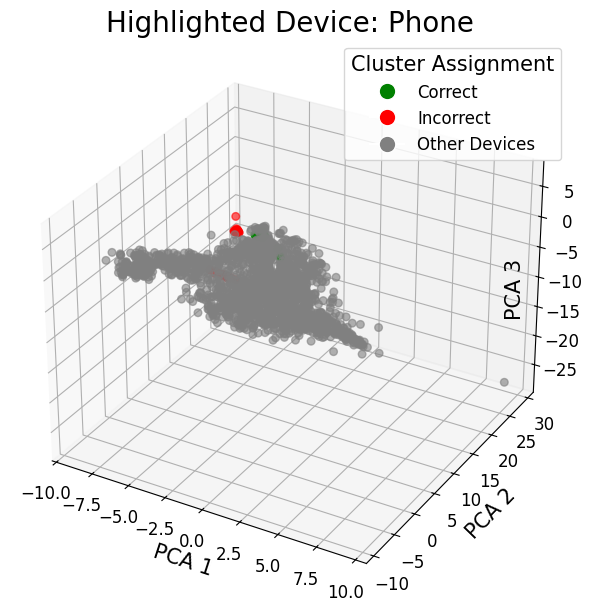

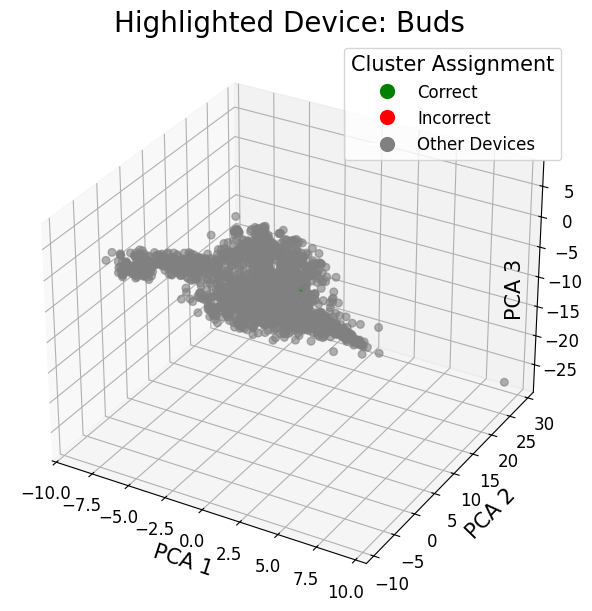

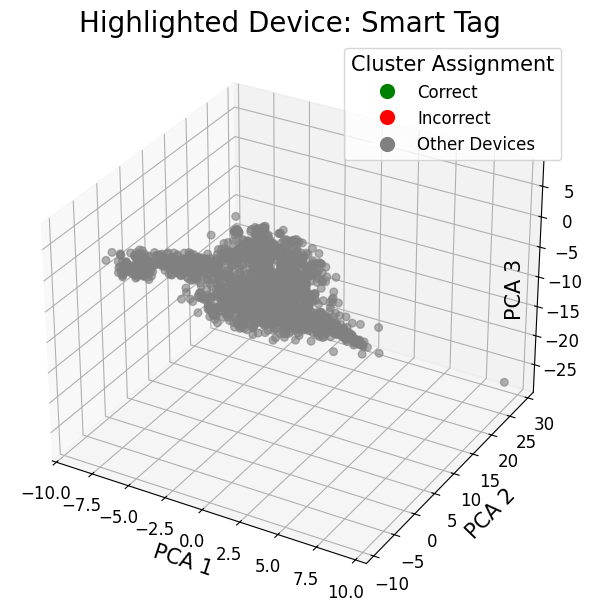

In [ ]:
###########################
#      CODE FIELD 13      #
###########################

current_labels = k_means_labels  # k_means_labels, birch_labels, bk_means_labels

# Build DataFrame safely by merging
labels_df = pd.DataFrame({
    'source': agg_df['source'].iloc[:len(current_labels)],  # align with labels
    'cluster_label': current_labels
})

df_to_analyze = labels_df.merge(
    eval_df_binned_balanced[['source', 'labelled_device', 'company_id']],
    on='source',
    how='left'
).drop_duplicates(subset='source')

# Determine the "correct" cluster for each device:
# This is the cluster that contains the majority of that device's points
device_correct_cluster = df_to_analyze.groupby('labelled_device')['cluster_label'] \
                                      .agg(lambda x: x.value_counts().idxmax())

# Add a column indicating whether each point is correctly assigned
df_to_analyze['correct_assignment'] = df_to_analyze.apply(
    lambda row: row['cluster_label'] == device_correct_cluster[row['labelled_device']], axis=1
)

# Count correct and incorrect assignments per device
device_assignment_counts = df_to_analyze.groupby('labelled_device')['correct_assignment'] \
                                        .value_counts().unstack(fill_value=0)
device_assignment_counts.rename(columns={True: 'Correct', False: 'Incorrect'}, inplace=True)
print("Correct/Incorrect assignments per device:\n", device_assignment_counts)

# PCA projection of the scaled data
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X_scaled)

# Map the sources to the device and correctness
mapped_df = df_to_analyze[['source', 'labelled_device', 'correct_assignment']].copy()

# Define the devices you want to visualize
devices_to_show = target_list

for device_to_show in devices_to_show:

    # Assign colors:
    # - Green: sample belongs to this device and is correctly assigned
    # - Red: sample belongs to this device but incorrectly assigned
    # - Gray: sample belongs to other devices
    colors = []
    for idx, row in mapped_df.iterrows():
        if row['labelled_device'] == device_to_show:
            colors.append('green' if row['correct_assignment'] else 'red')
        else:
            colors.append('gray')

    # Plotting
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=colors, alpha=0.6, s=30)
    ax1.set_title(f'Highlighted Device: {device_to_show}', fontsize=20)
    ax1.set_xlabel('PCA 1', fontsize=15)
    ax1.set_ylabel('PCA 2', fontsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=12)  
    ax1.tick_params(axis='z', which='major', labelsize=12)     

    # Legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'Correct',
               markerfacecolor='green', markersize=12),
        Line2D([0], [0], marker='o', color='w', label=f'Incorrect',
               markerfacecolor='red', markersize=12),
        Line2D([0], [0], marker='o', color='w', label='Other Devices',
               markerfacecolor='gray', markersize=12),
    ]
    ax1.legend(handles=legend_elements, title='Cluster Assignment', title_fontsize=15, fontsize=12)


    ax1.set_zlabel("") 
    ax1.text2D(
        0.92, 
        0.5, 
        "PCA 3",
        transform=ax1.transAxes,
        rotation=90,
        va="bottom",
        ha="right", 
        fontsize=15
        )

    plt.tight_layout()
    plt.show()
